# Data analysis

In [1]:
import json
import sys
import networkx
import pandas
import numpy

import matplotlib.pyplot as plotter
from pathlib import Path

Data dir containing all files

In [2]:
!ls -la /home/ashinde/PhD/CaffineBravery/

total 44
drwxr-xr-x 20 ashinde ashinde 4096 Feb  2 17:23 .
drwxrwxr-x  6 ashinde ashinde   84 Dec  7 19:05 ..
drwxr-xr-x  7 ashinde ashinde  124 Nov 15 11:34 app
drwxr-xr-x  4 ashinde ashinde  142 Oct 15 15:33 domains
drwxr-xr-x  8 ashinde ashinde  220 Jan 31 20:16 .git
-rw-r--r--  1 ashinde ashinde  154 May 24  2022 .gitattributes
-rw-r--r--  1 ashinde ashinde  129 May 24  2022 .gitignore
drwxrwxr-x  6 ashinde ashinde   73 Jun  7  2022 .gradle
drwxr-xr-x  3 ashinde ashinde   21 May 24  2022 gradle
-rwxr-xr-x  1 ashinde ashinde 5774 May 24  2022 gradlew
-rw-r--r--  1 ashinde ashinde 2763 May 24  2022 gradlew.bat
drwxrwxr-x  2 ashinde ashinde   52 Jul 19  2022 policies
-rw-rw-r--  1 ashinde ashinde  743 Jun  7  2022 .project
drwxrwxr-x  2 ashinde ashinde   62 Nov 29 12:57 results
drwxrwxr-x  2 ashinde ashinde  101 Feb  1 18:21 results_l1_active
drwxrwxr-x  2 ashinde ashinde   63 Feb  2 14:29 results_l1_active_control
drwxrwxr-x  2 ashinde ashinde  100 Nov 29 21:44 results_l1_active_crit

In [3]:
# Data files
data_dir = Path("/home/ashinde/PhD/CaffineBravery/results_l2_control/")
data_files = list(data_dir.iterdir())

graph_files = list(filter(lambda x: "pol_graph" in str(x), data_files))
print(f"Policy graph files: {graph_files}")

trace_file = list(filter(lambda x: "trace" in str(x), data_files))[0]
print(f"Trace file: {trace_file}")

Policy graph files: [PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/1048712791_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/25936709_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/500618423_defl1_active_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/1458091526_defl1_passive_pol_graph.json')]
Trace file: /home/ashinde/PhD/CaffineBravery/results_l2_control/trace.json


In [4]:
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data

In [5]:
# Draw policy graphs
def to_networkx_graph(json_data):

    nodes = json_data["nodes"]
    edges = json_data["edges"]

    G = networkx.MultiDiGraph()
    labels = {}
    edge_labels = {}
    edge_print = {}

    for k, v in nodes.items():
        
        if "start" in v.keys():
            labels[k] = f"start_{v['act']}"
        else:
            labels[k] = v["act"]
        G.add_node(k)
        
    for n, e in edges.items():
        for l, _n in e.items():
            G.add_edge(n, _n, label=l)
            
            e_data = G.get_edge_data(n, _n)
            label = [l["label"] for l in e_data.values()]
            # print(label)
            edge_labels[(n, _n)] = list(e_data.keys())

    # pos = networkx.shell_layout(G, scale=1)
    # networkx.draw_networkx_labels(G, pos, labels)
    
    print(G)
    pos = networkx.nx_pydot.graphviz_layout(G, prog="neato")
    networkx.draw(G, pos, labels=labels, with_labels=True, font_size=8, alpha=0.5, width=0.2)
    plotter.show()

---
## Plot policy graphs

/home/ashinde/PhD/CaffineBravery/results_l2_control/1048712791_attl0_pol_graph.json
MultiDiGraph with 13 nodes and 92 edges


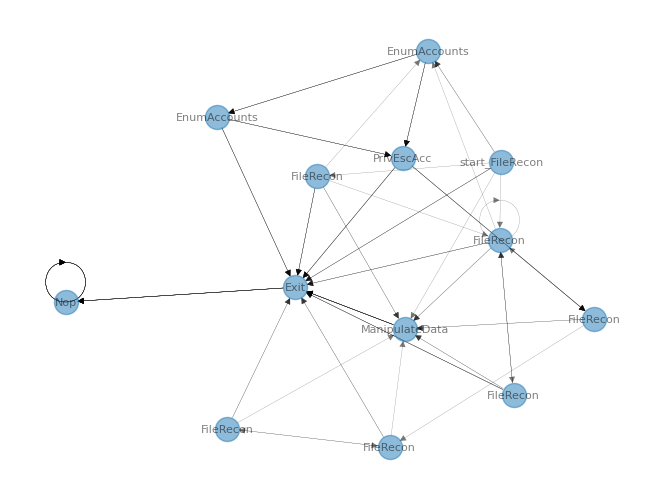

/home/ashinde/PhD/CaffineBravery/results_l2_control/25936709_attl0_pol_graph.json
MultiDiGraph with 11 nodes and 80 edges


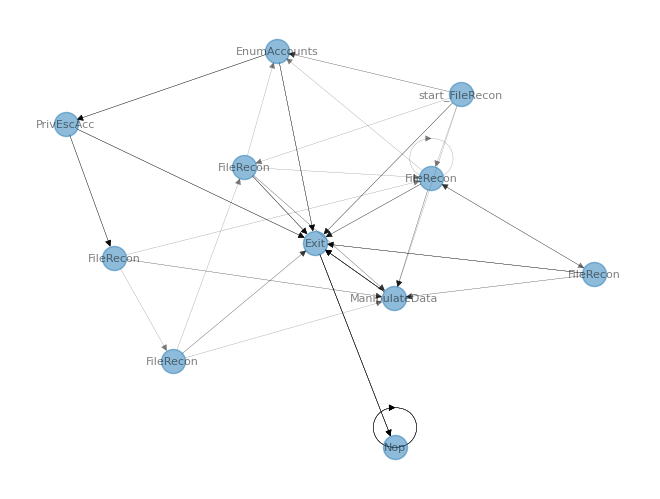

/home/ashinde/PhD/CaffineBravery/results_l2_control/500618423_defl1_active_pol_graph.json
MultiDiGraph with 14 nodes and 56 edges


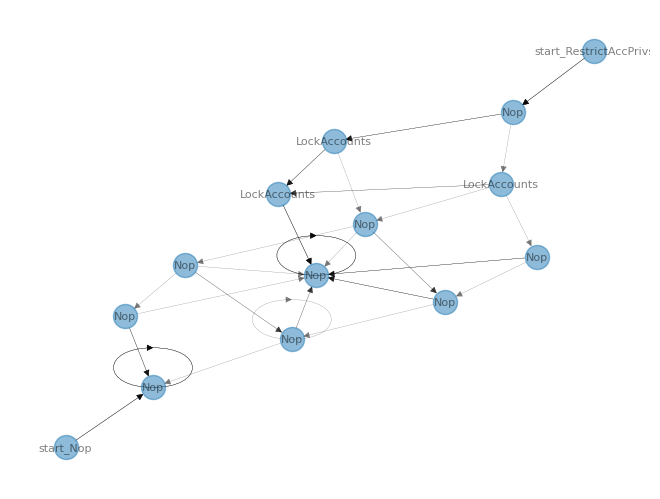

/home/ashinde/PhD/CaffineBravery/results_l2_control/1458091526_defl1_passive_pol_graph.json
MultiDiGraph with 27 nodes and 108 edges


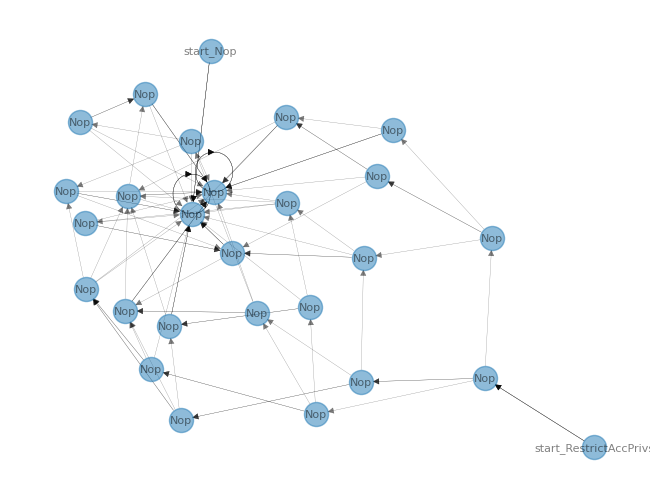

In [6]:
for g in graph_files:
    print(g)
    data = load_json(g)
    to_networkx_graph(data)

---
## Beliefs 

In [7]:
import summarize_interaction

# load json data
data = load_json(trace_file)

keys, b_traces = summarize_interaction.get_all_belief_traces(data)

print("Plotting belief divergence over")
for k in keys:
    print(k)

Plotting belief divergence over
('HostType', ['critical', 'critical_honeypot', 'honeypot'])
('HostHasData', ['no', 'yes'])
('DataPrivs', ['root', 'user'])
('EscAccounts', ['no', 'yes'])
('AccFound', ['no', 'yes'])
('DataFound', ['no', 'yes'])
('AccessLevel', ['root', 'user'])
('AttActive', ['no', 'yes'])
('DataInjected', ['no', 'yes'])


Plotting for ('HostType', ['critical', 'critical_honeypot', 'honeypot'])


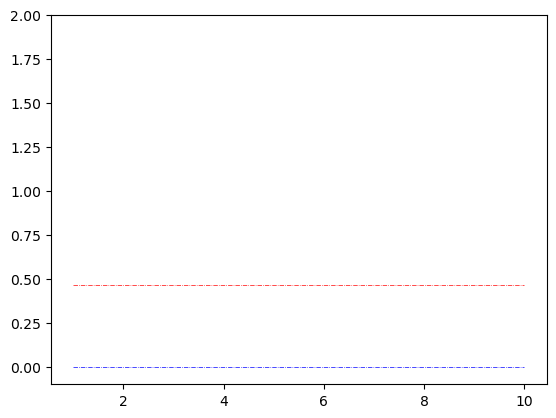

Plotting for ('HostHasData', ['no', 'yes'])


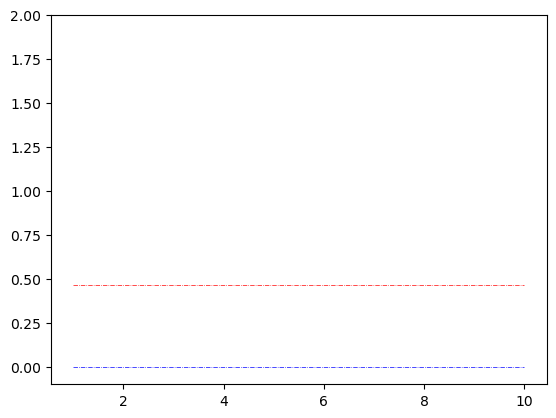

Plotting for ('DataPrivs', ['root', 'user'])


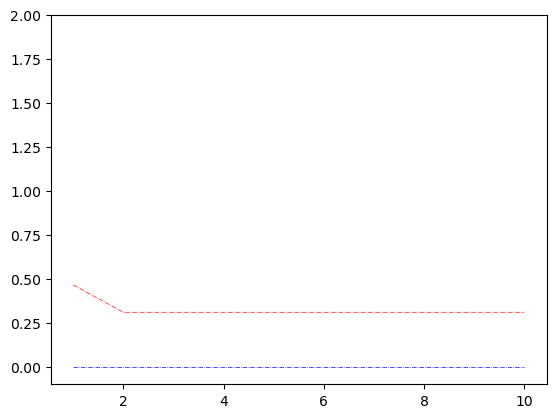

Plotting for ('EscAccounts', ['no', 'yes'])


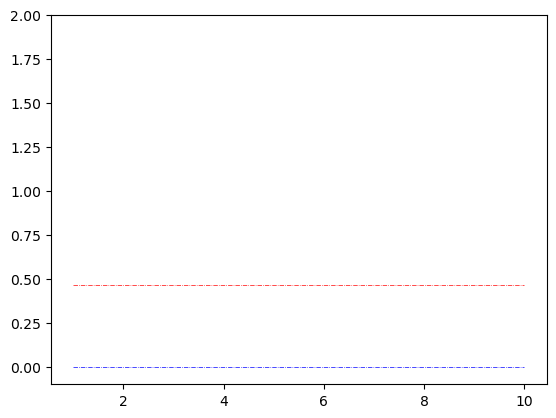

Plotting for ('AccFound', ['no', 'yes'])


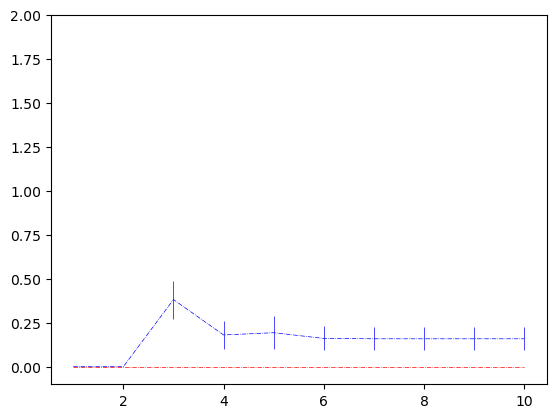

Plotting for ('DataFound', ['no', 'yes'])


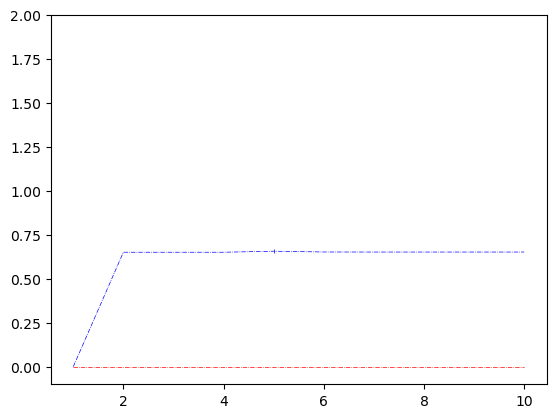

Plotting for ('AccessLevel', ['root', 'user'])


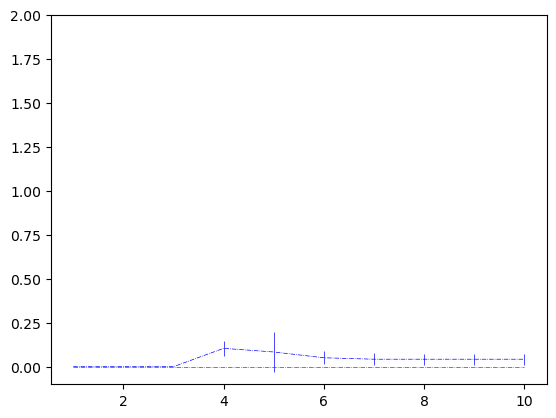

Plotting for ('AttActive', ['no', 'yes'])


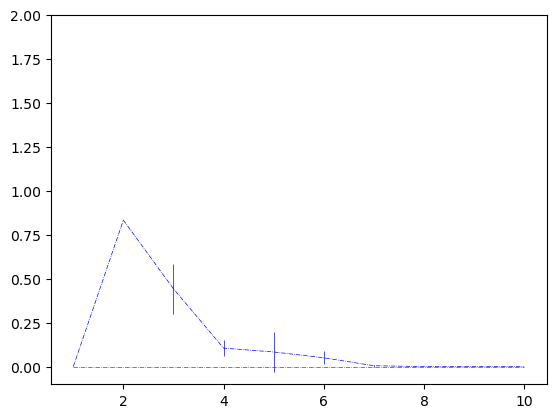

Plotting for ('DataInjected', ['no', 'yes'])


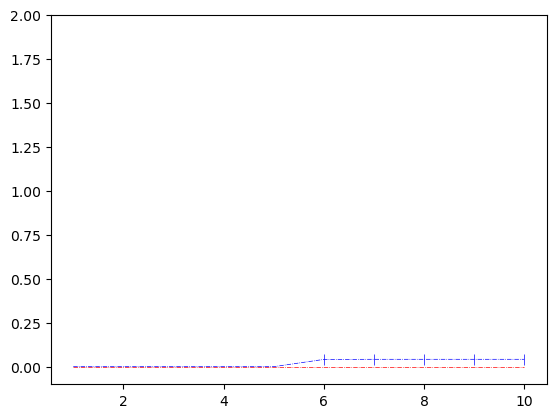

In [8]:
# Get divergence
divs = []
for b_trace in b_traces:
    divs.append(summarize_interaction.get_divergence(b_trace))
    
for i in range(len(keys)):
    print(f"Plotting for {keys[i]}")
    
    i_means = numpy.mean(divs[i][0], axis=0)
    i_dev = numpy.std(divs[i][0], axis=0)
    plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)
    
    if len(divs[i]) > 1:
        j_means = numpy.mean(divs[i][1], axis=0)
        j_dev = numpy.std(divs[i][1], axis=0)
        plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
        # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)
    
    plotter.ylim(-0.1, 2)
    plotter.show()
    

---
# Display interaction examples

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|user_files|success|terminated|none,RestrictAccPrivs,none
1,Nop,auth|user_files|failure|terminated|none,Nop,login_activity
2,Nop,auth|none|success|terminated|none,Nop,none
3,Nop,denied|none|failure|terminated|none,Nop,none
4,Nop,denied|none|success|terminated|none,Nop,file_enum
5,Nop,denied|user_files|success|terminated|none,Nop,none
6,Nop,auth|none|failure|terminated|none,Nop,none
7,Nop,denied|none|failure|terminated|none,Nop,none
8,Nop,denied|user_files|failure|terminated|none,Nop,none
9,Nop,auth|none|success|terminated|none,Nop,none


0	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.5, 'RestrictAccPrivs': 0.5}}
1	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
2	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
3	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
4	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
5	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
6	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0000001, 'RestrictAccPrivs': 0.0}}
7	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.99999994, 'RestrictAccPrivs': 0.0}}
8	{'DefActions': {'DecoyAccount': 0.0, 'DeployData'

,highCap,lowCap
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


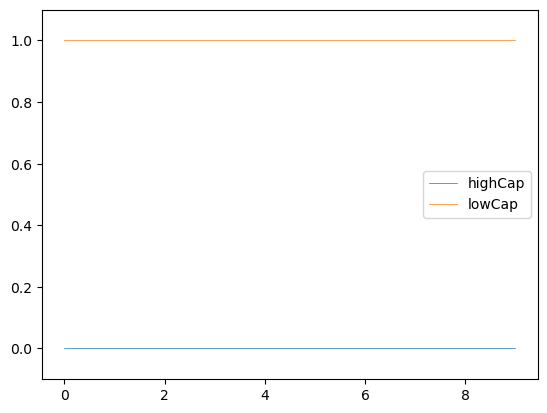

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


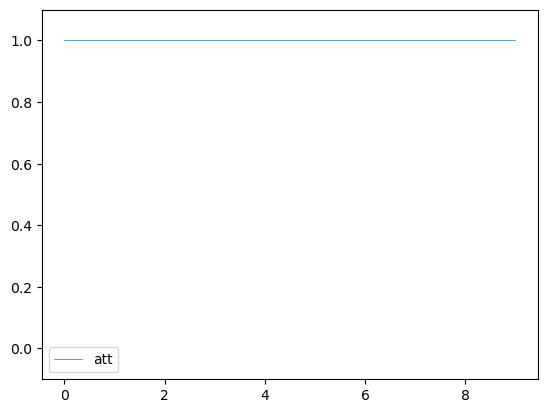

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


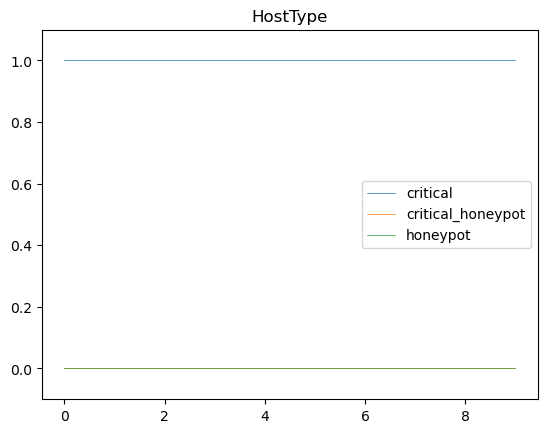

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


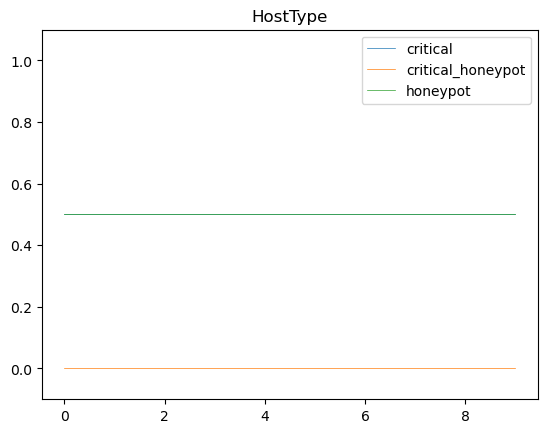

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


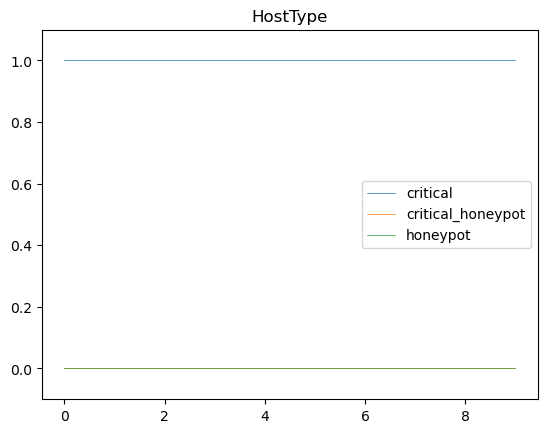

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


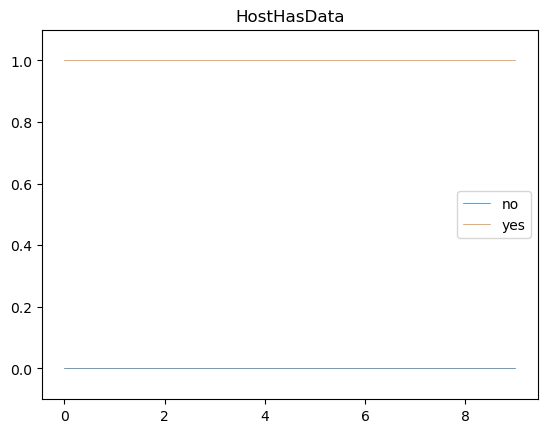

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


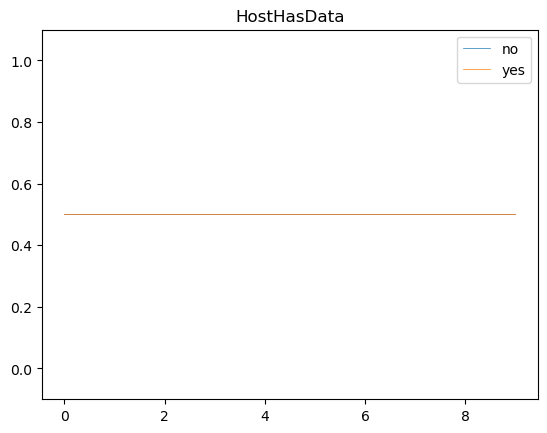

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


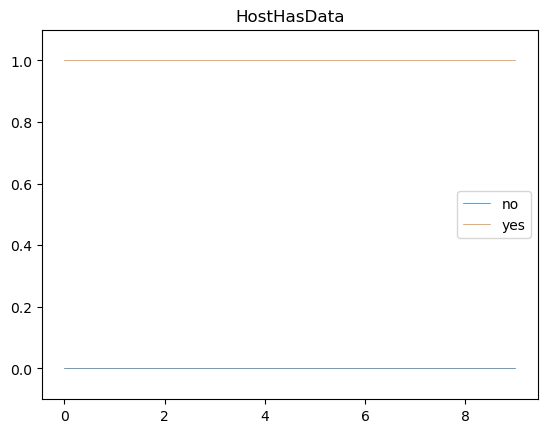

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


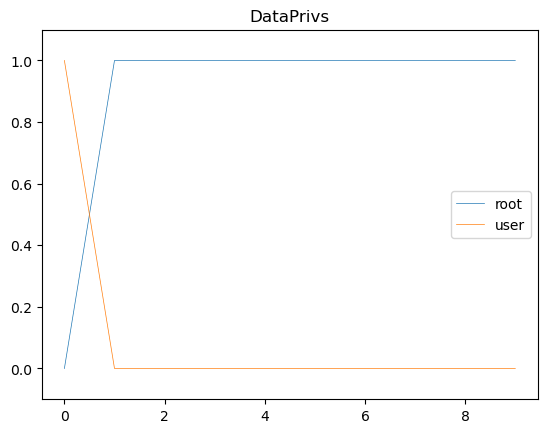

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.50,0.50
1,0.75,0.25
2,0.75,0.25
3,0.75,0.25
4,0.75,0.25
5,0.75,0.25
6,0.75,0.25
7,0.75,0.25
8,0.75,0.25
9,0.75,0.25


Plotting ('DataPrivs', ['root', 'user']) for agent_i


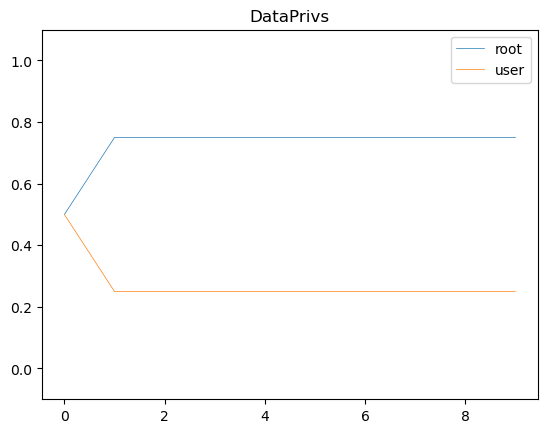

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


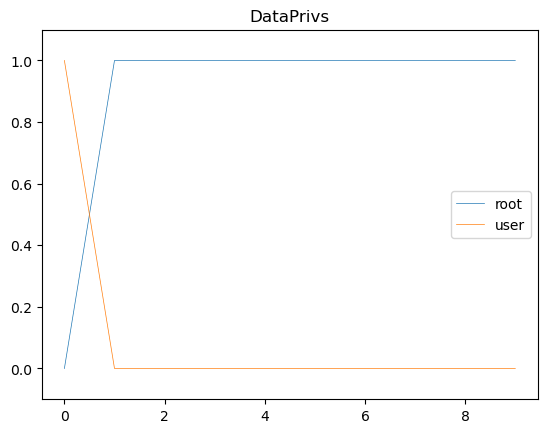

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


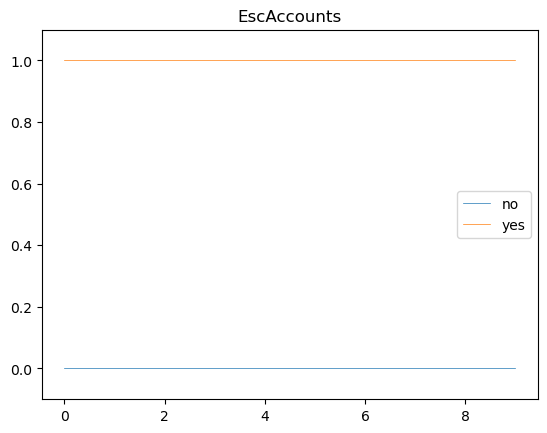

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


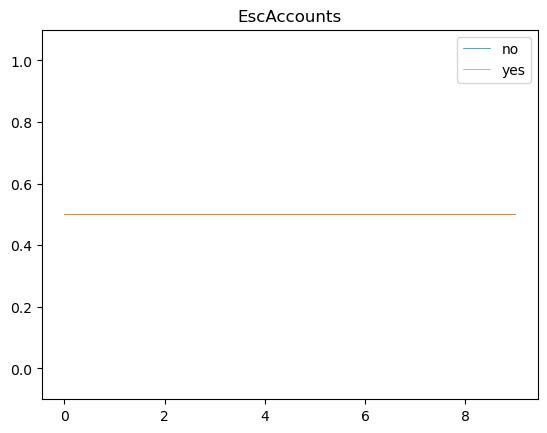

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


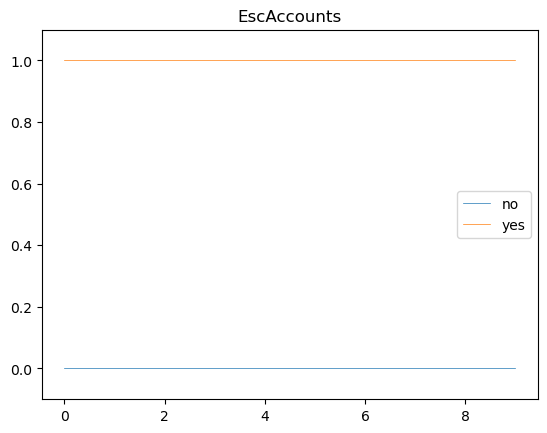

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


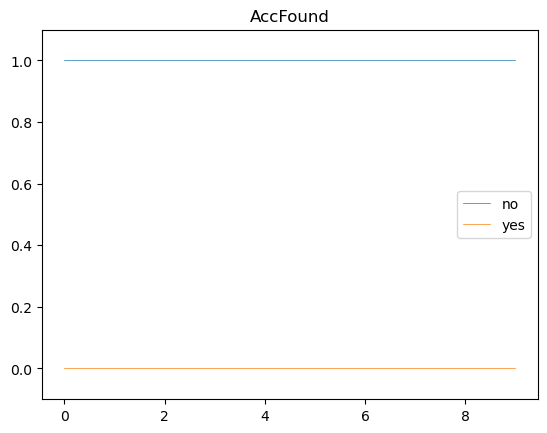

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


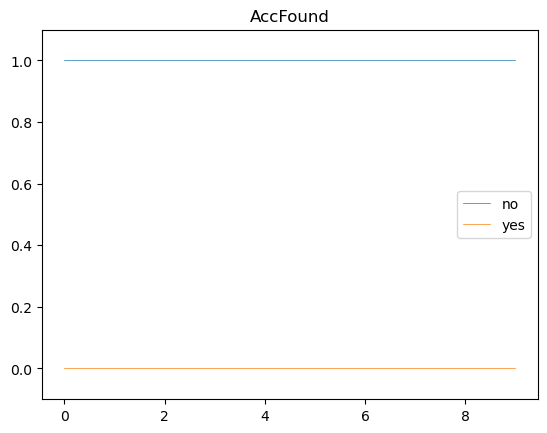

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.280000,0.720000
3,0.704918,0.295082
4,0.779893,0.220107
5,0.769096,0.230904
6,0.779595,0.220405
7,0.779663,0.220337
8,0.779663,0.220337
9,0.779663,0.220337


Plotting ('AccFound', ['no', 'yes']) for agent_j


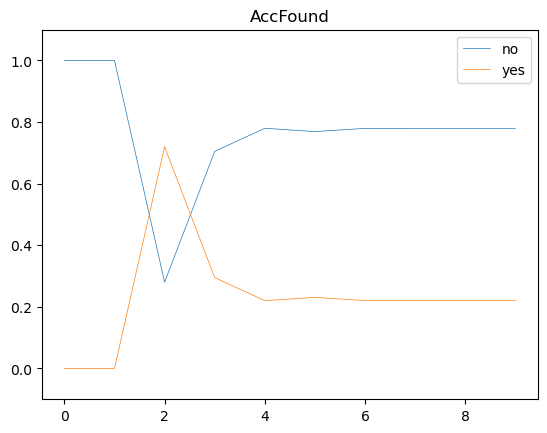

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


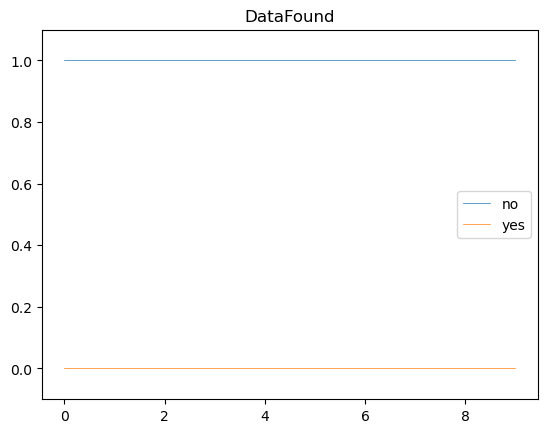

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


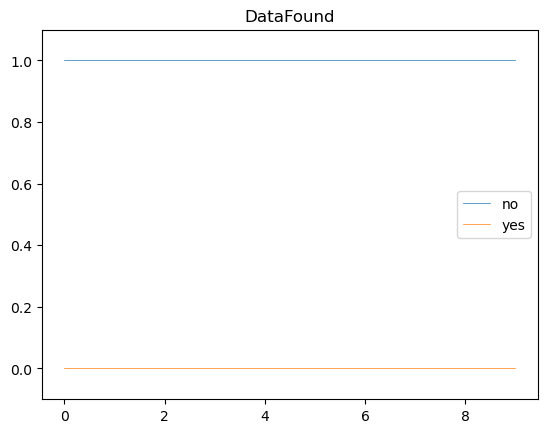

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.200000,0.800000
4,0.198936,0.801064
5,0.196748,0.803251
6,0.198772,0.801228
7,0.198789,0.801211
8,0.198789,0.801211
9,0.198789,0.801211


Plotting ('DataFound', ['no', 'yes']) for agent_j


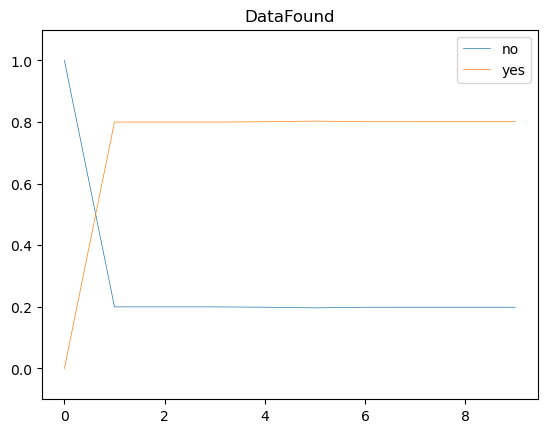

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


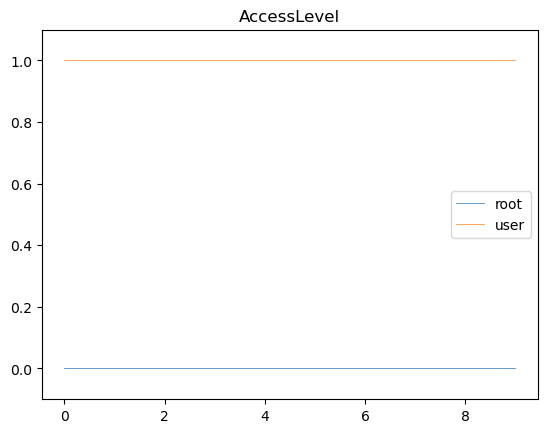

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


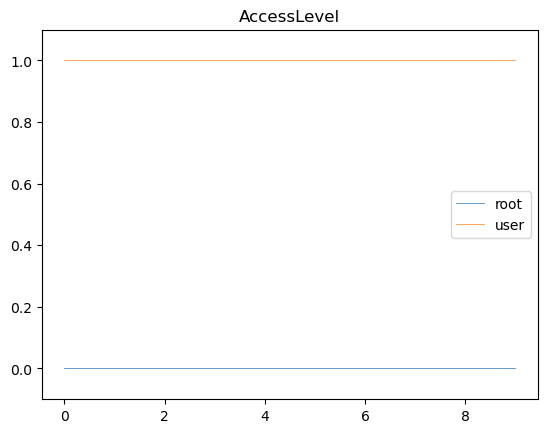

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.102144,0.897856
4,0.006648,0.993353
5,0.020401,0.979599
6,0.007028,0.992972
7,0.006941,0.993059
8,0.006941,0.993059
9,0.006941,0.993059


Plotting ('AccessLevel', ['root', 'user']) for agent_j


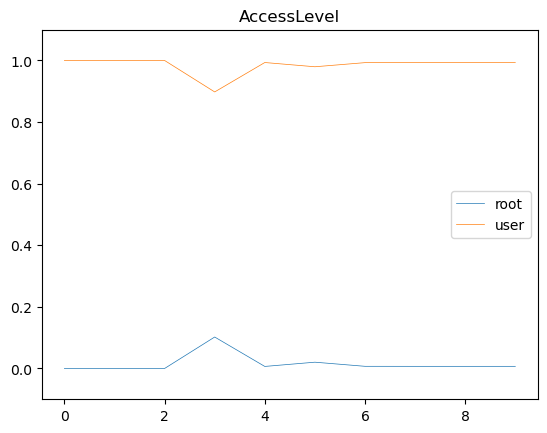

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


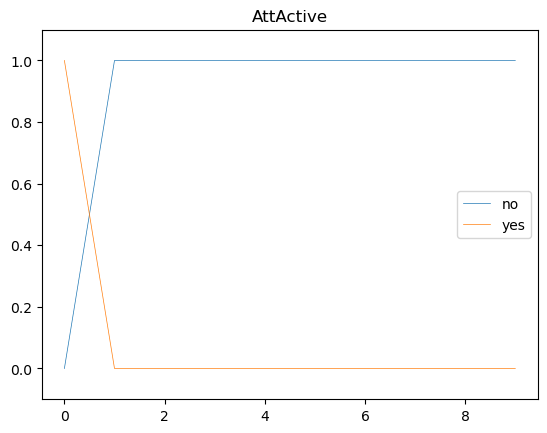

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


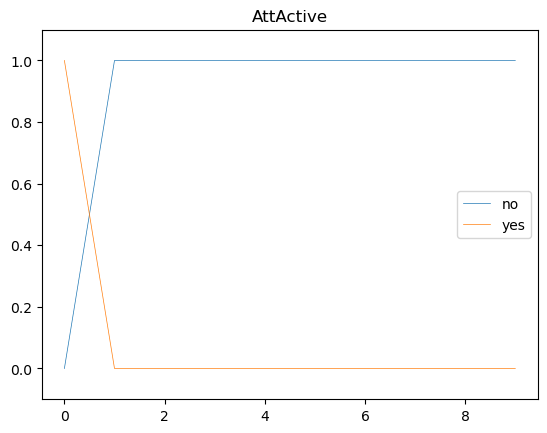

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.100000,0.900000
3,0.895019,0.104981
4,0.993353,0.006648
5,0.979599,0.020401
6,0.999147,0.000853
7,0.999995,0.000005
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


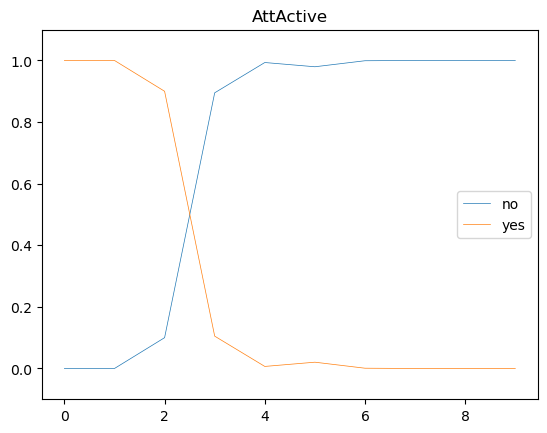

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


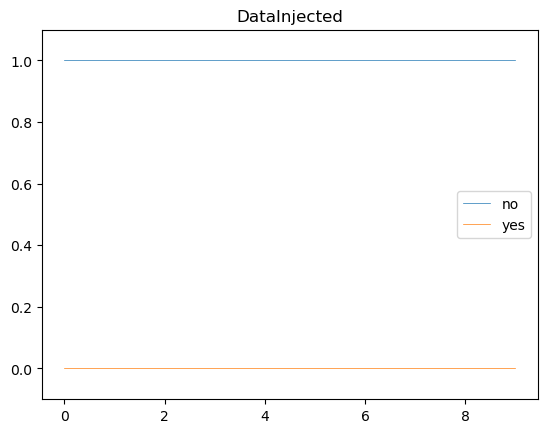

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


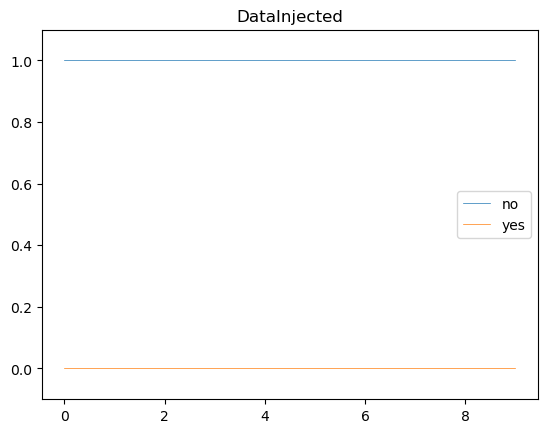

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.994336,0.005664
6,0.993520,0.006480
7,0.993514,0.006486
8,0.993514,0.006486
9,0.993514,0.006486


Plotting ('DataInjected', ['no', 'yes']) for agent_j


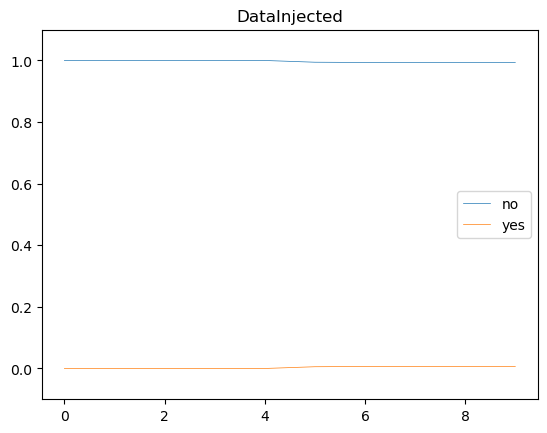

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,denied|user_files|failure|terminated|none,RestrictAccPrivs,none
1,Nop,denied|user_files|failure|terminated|none,Nop,none
2,Nop,denied|none|success|terminated|none,Nop,none
3,Nop,auth|user_files|failure|terminated|none,Nop,file_enum
4,Nop,auth|user_files|failure|terminated|none,Nop,none
5,Nop,auth|user_files|failure|terminated|none,Nop,none
6,Nop,auth|user_files|failure|terminated|none,Nop,none
7,Nop,denied|user_files|failure|terminated|none,Nop,none
8,Nop,auth|none|failure|terminated|none,Nop,none
9,Nop,denied|user_files|success|terminated|none,Nop,none


0	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.5, 'RestrictAccPrivs': 0.5}}
1	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
2	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
3	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
4	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
5	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
6	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0000001, 'RestrictAccPrivs': 0.0}}
7	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.99999994, 'RestrictAccPrivs': 0.0}}
8	{'DefActions': {'DecoyAccount': 0.0, 'DeployData'

,highCap,lowCap
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


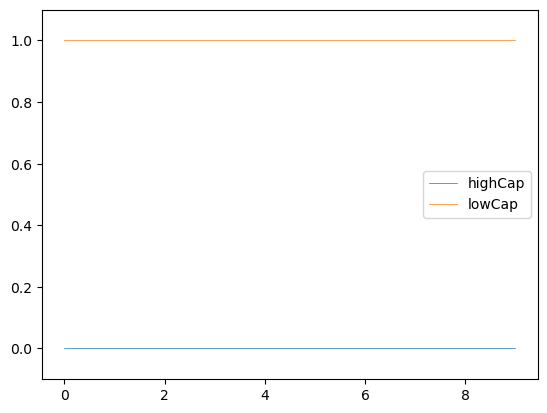

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


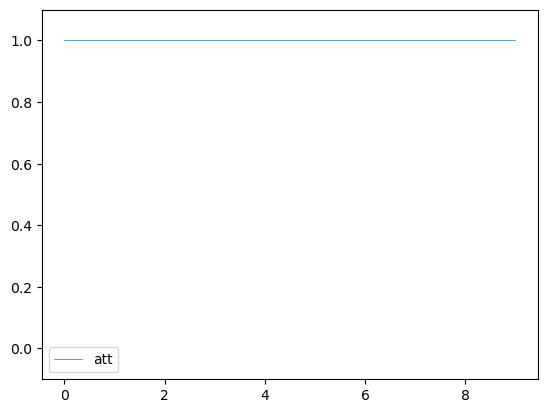

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


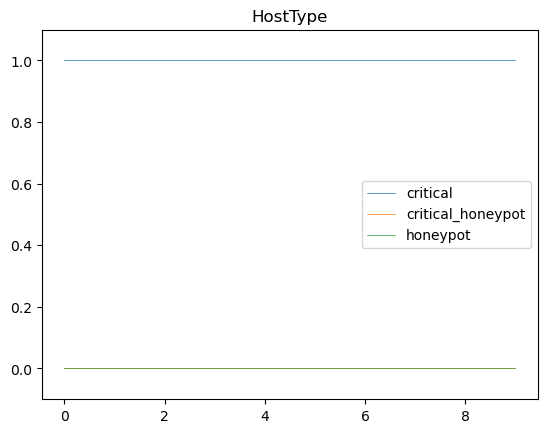

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


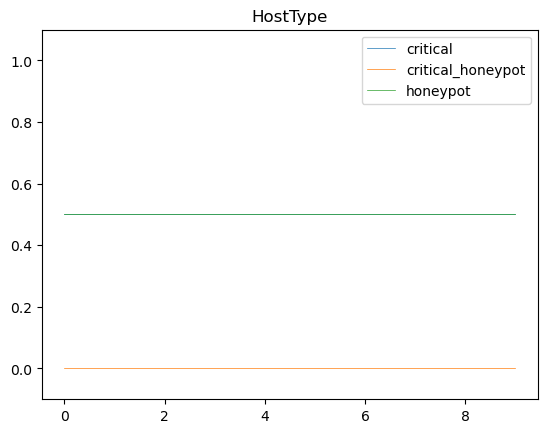

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


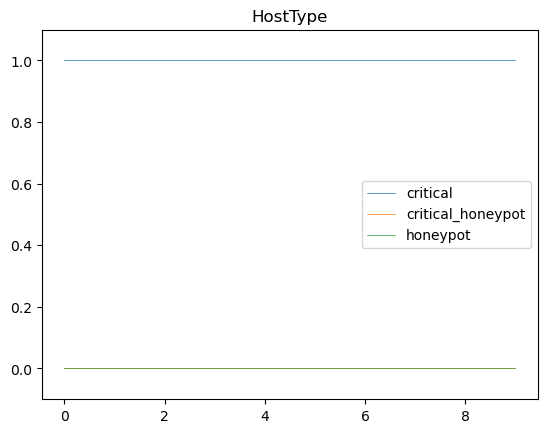

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


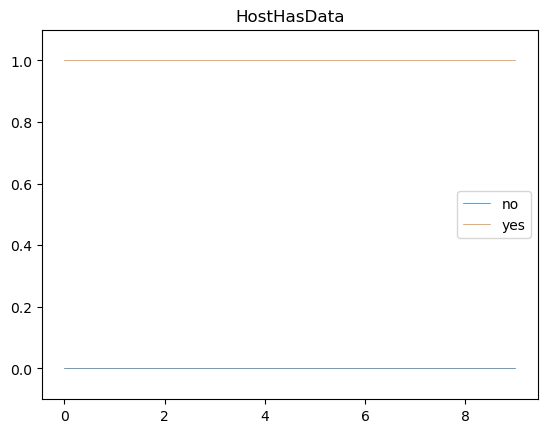

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


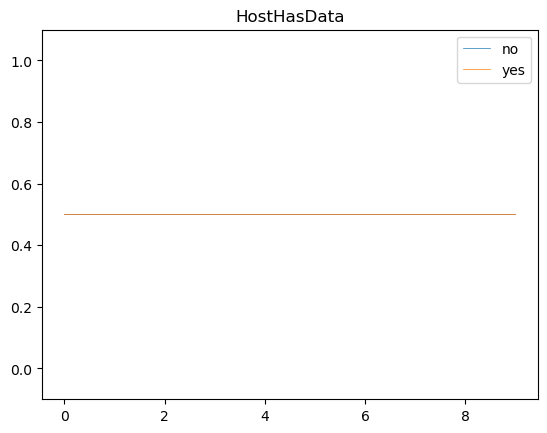

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


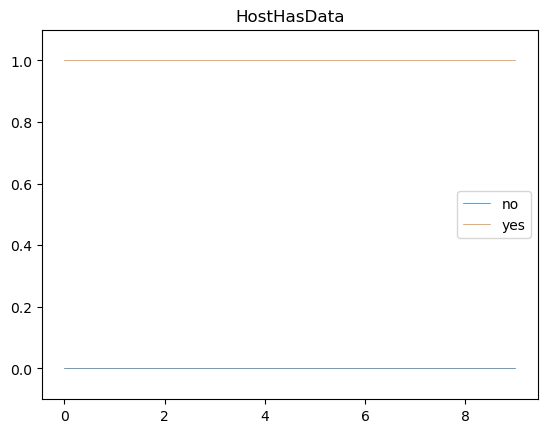

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


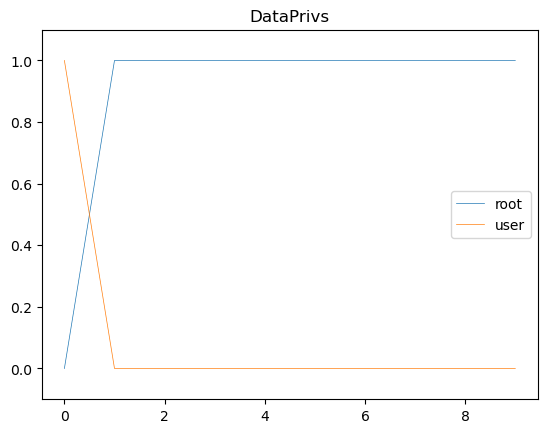

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.50,0.50
1,0.75,0.25
2,0.75,0.25
3,0.75,0.25
4,0.75,0.25
5,0.75,0.25
6,0.75,0.25
7,0.75,0.25
8,0.75,0.25
9,0.75,0.25


Plotting ('DataPrivs', ['root', 'user']) for agent_i


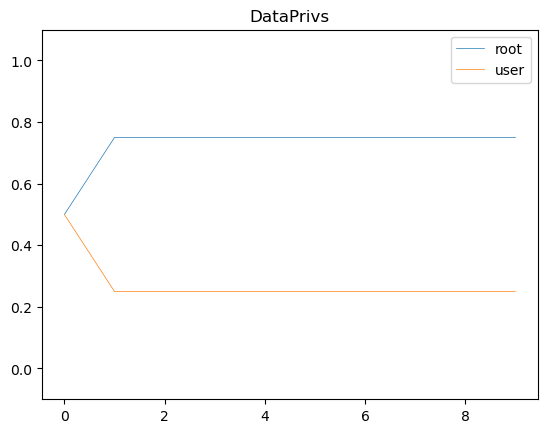

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


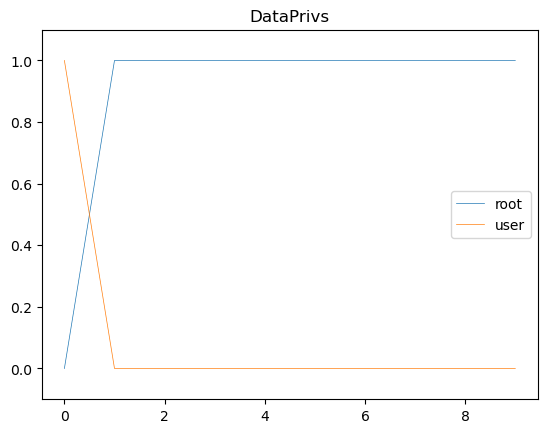

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


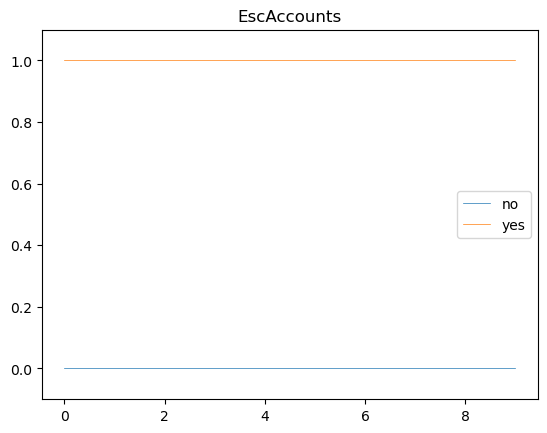

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


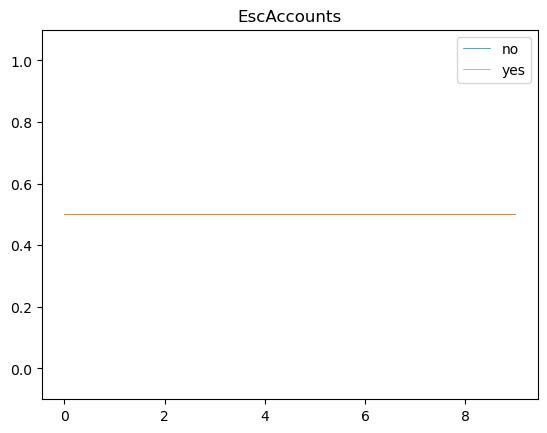

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


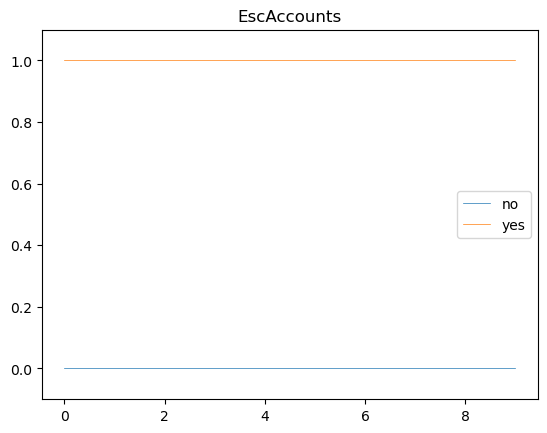

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


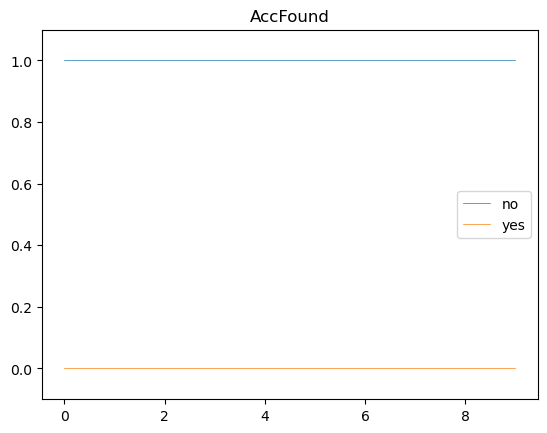

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


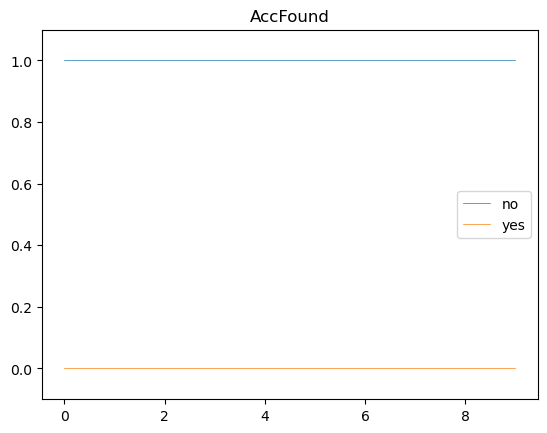

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.723077,0.276923
3,0.944193,0.055807
4,0.721261,0.278739
5,0.944193,0.055807
6,0.946402,0.053598
7,0.946416,0.053584
8,0.946416,0.053584
9,0.946416,0.053584


Plotting ('AccFound', ['no', 'yes']) for agent_j


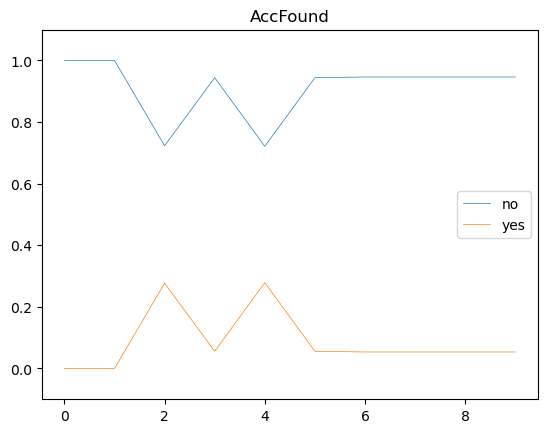

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


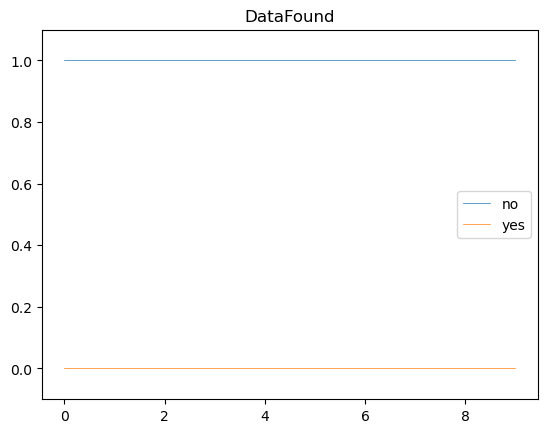

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


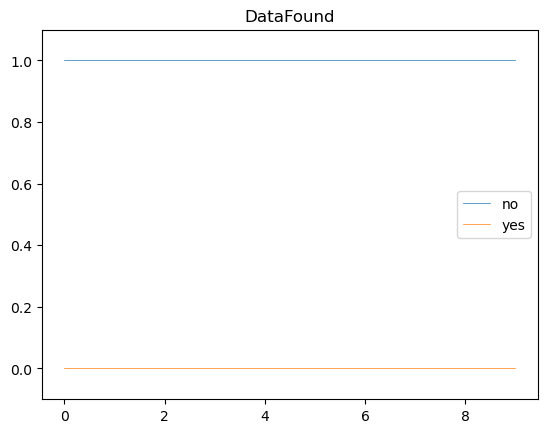

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.200000,0.800000
4,0.159862,0.840139
5,0.196353,0.803647
6,0.196699,0.803301
7,0.196702,0.803299
8,0.196702,0.803299
9,0.196702,0.803299


Plotting ('DataFound', ['no', 'yes']) for agent_j


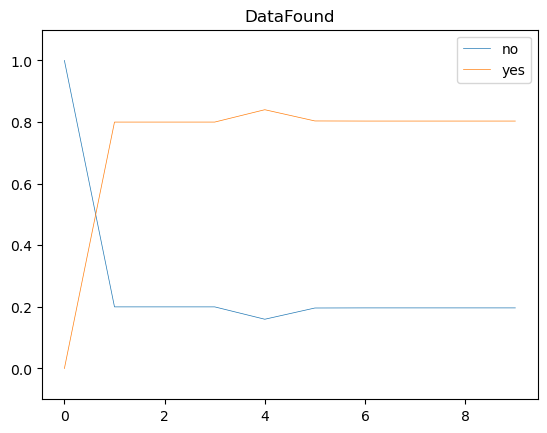

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


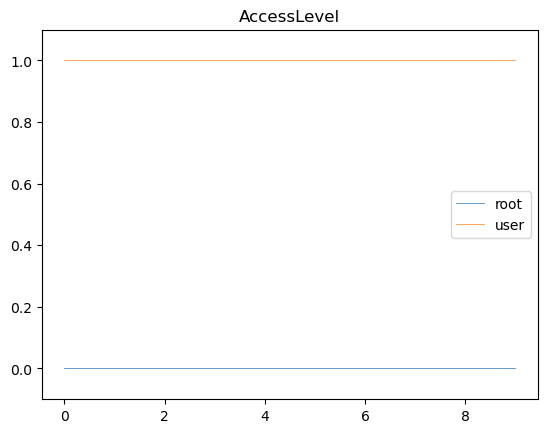

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


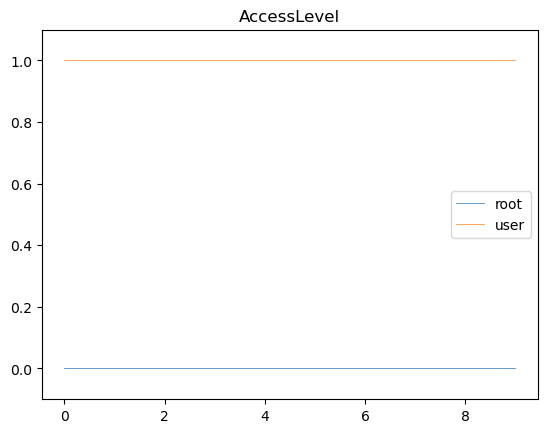

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.019318,0.980682
4,0.250865,0.749135
5,0.019318,0.980682
6,0.017023,0.982977
7,0.017008,0.982992
8,0.017008,0.982992
9,0.017008,0.982992


Plotting ('AccessLevel', ['root', 'user']) for agent_j


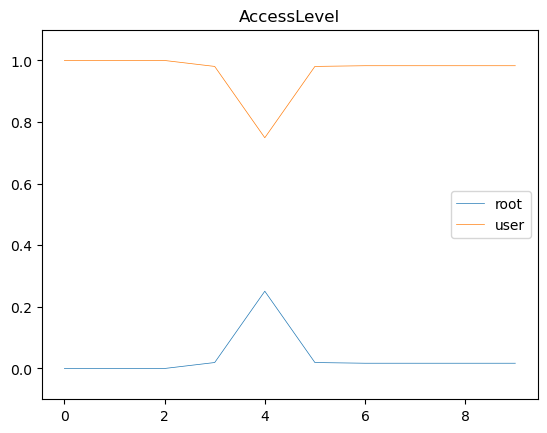

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


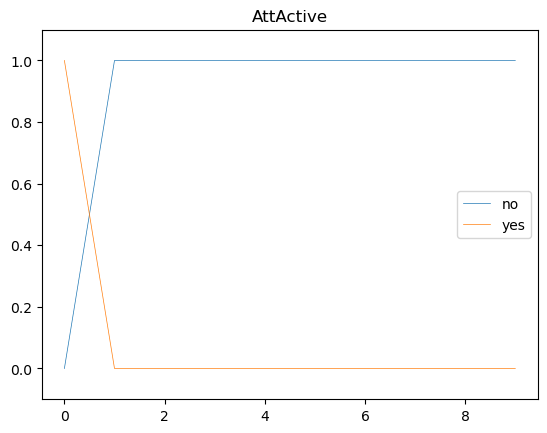

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


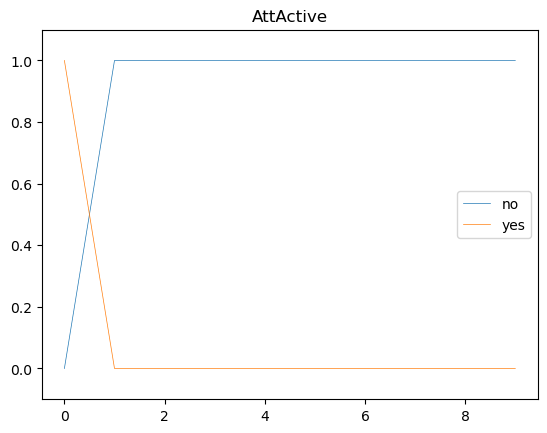

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.653846,3.461539e-01
3,0.980145,1.985452e-02
4,0.749135,2.508653e-01
5,0.980682,1.931791e-02
6,0.999854,1.462457e-04
7,0.999999,9.379787e-07
8,1.000000,0.000000e+00
9,1.000000,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


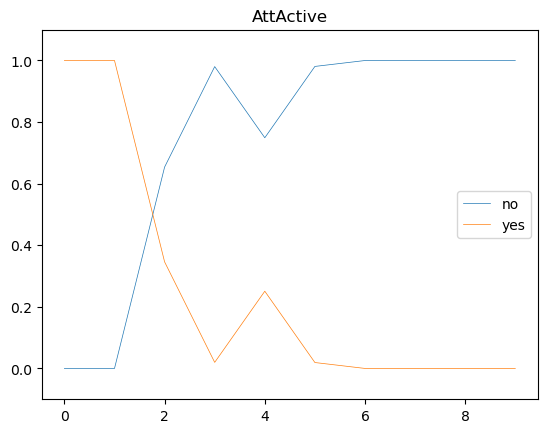

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


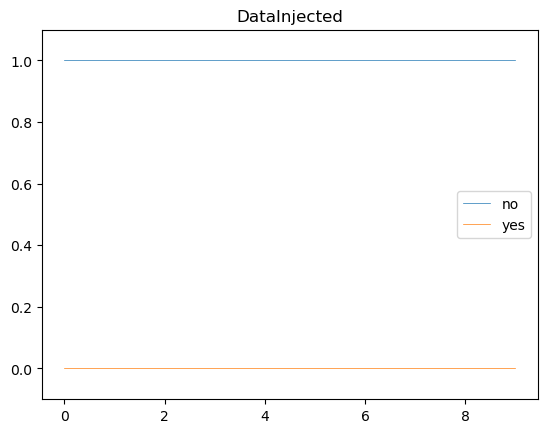

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


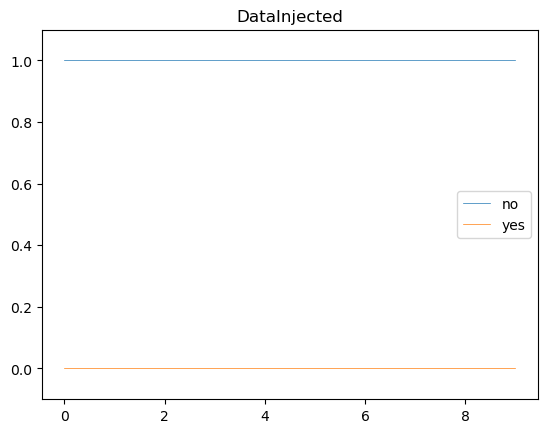

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.983309,0.016691
6,0.983144,0.016856
7,0.983142,0.016858
8,0.983142,0.016858
9,0.983142,0.016858


Plotting ('DataInjected', ['no', 'yes']) for agent_j


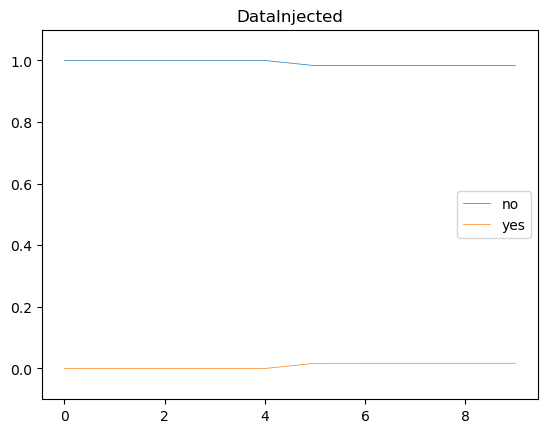

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|user_files|failure|terminated|none,RestrictAccPrivs,none
1,Nop,denied|user_files|failure|terminated|none,Nop,none
2,Nop,denied|none|failure|terminated|none,Nop,none
3,Nop,auth|user_files|success|terminated|none,Nop,none
4,Nop,denied|user_files|success|terminated|none,Nop,file_write
5,Nop,denied|none|success|terminated|none,Nop,none
6,Nop,auth|user_files|success|terminated|none,Nop,none
7,Nop,denied|none|success|terminated|none,Nop,none
8,Nop,denied|user_files|failure|terminated|none,Nop,none
9,Nop,auth|user_files|success|terminated|none,Nop,none


0	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.5, 'RestrictAccPrivs': 0.5}}
1	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
2	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
3	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
4	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
5	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
6	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0000001, 'RestrictAccPrivs': 0.0}}
7	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.99999994, 'RestrictAccPrivs': 0.0}}
8	{'DefActions': {'DecoyAccount': 0.0, 'DeployData'

,highCap,lowCap
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


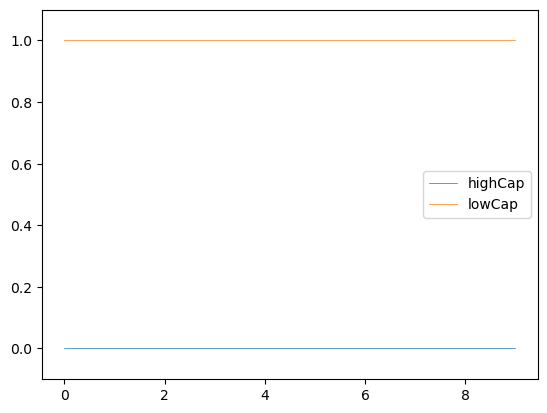

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


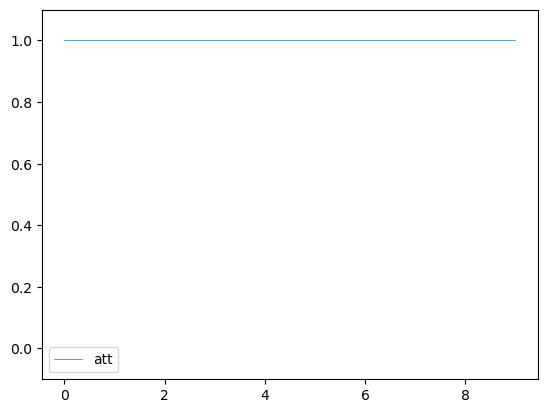

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


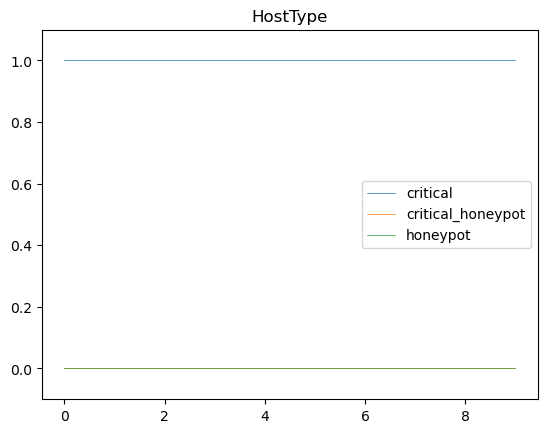

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


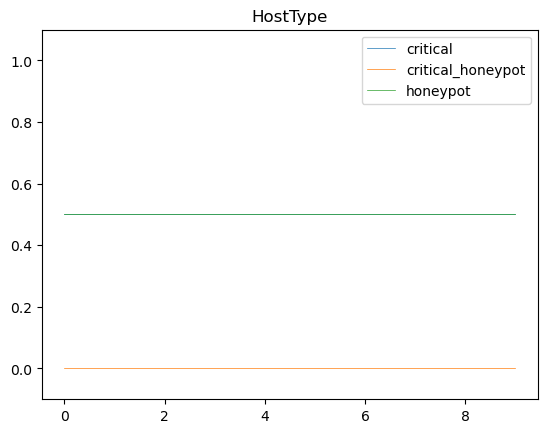

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


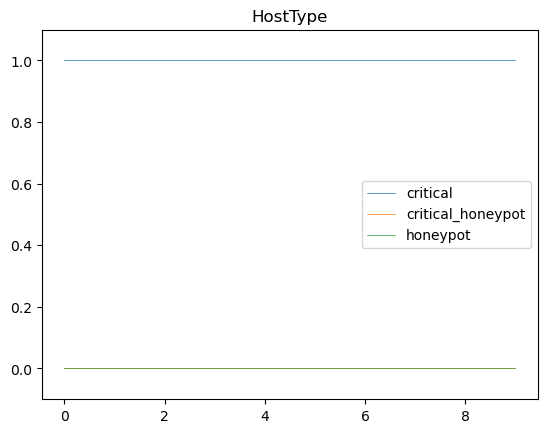

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


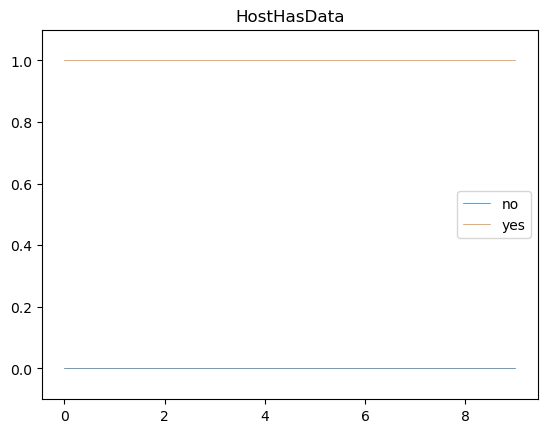

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


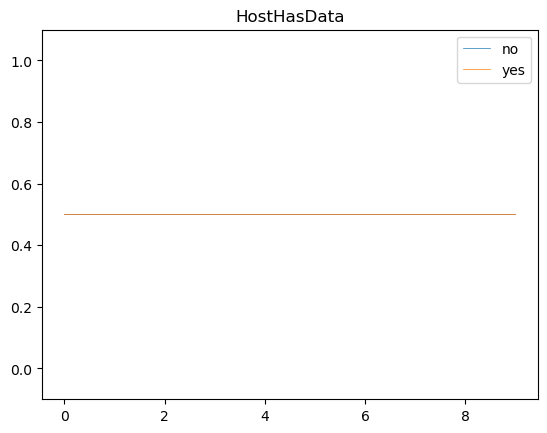

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


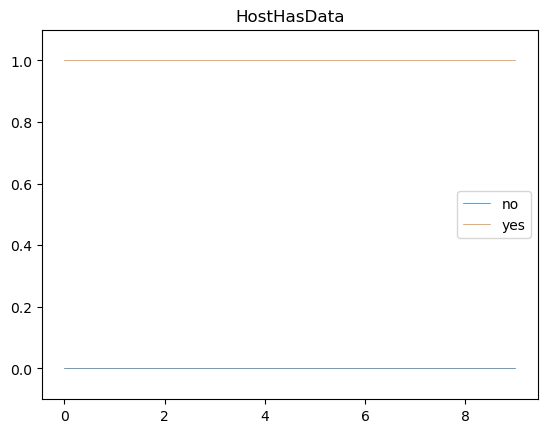

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


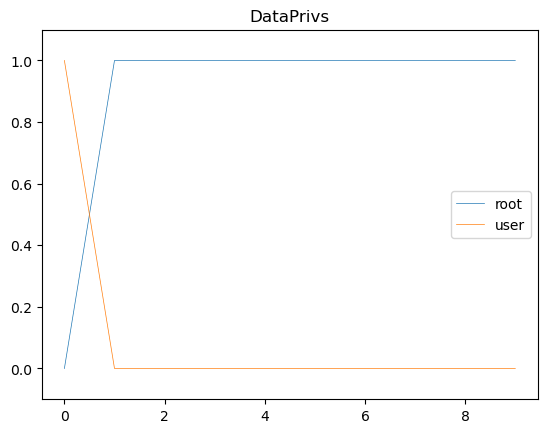

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.50,0.50
1,0.75,0.25
2,0.75,0.25
3,0.75,0.25
4,0.75,0.25
5,0.75,0.25
6,0.75,0.25
7,0.75,0.25
8,0.75,0.25
9,0.75,0.25


Plotting ('DataPrivs', ['root', 'user']) for agent_i


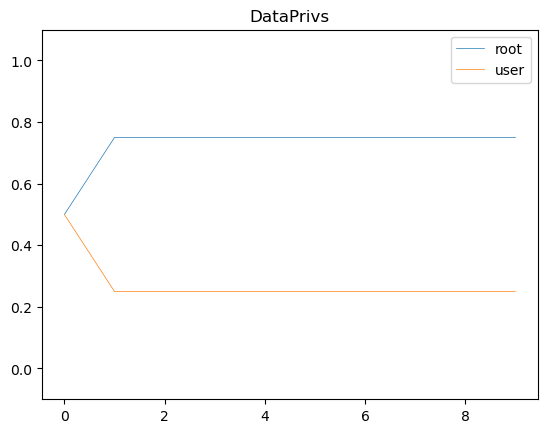

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


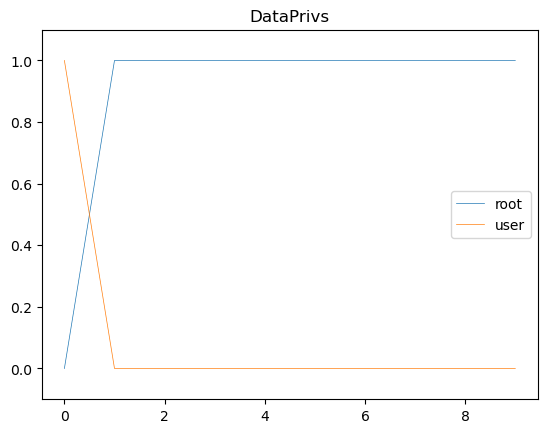

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


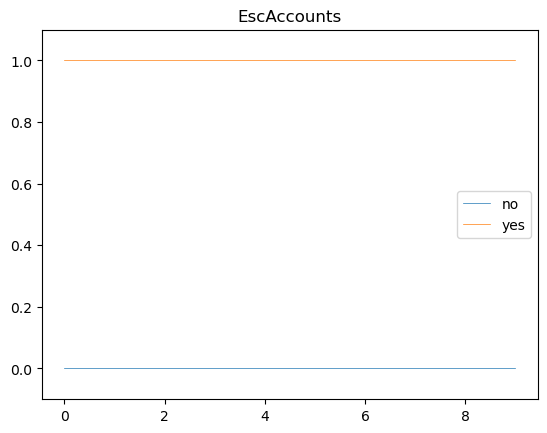

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


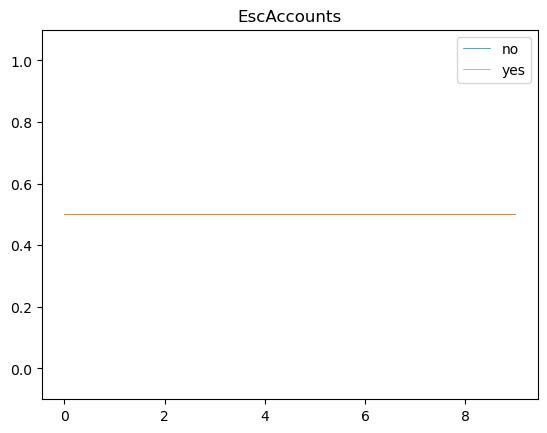

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


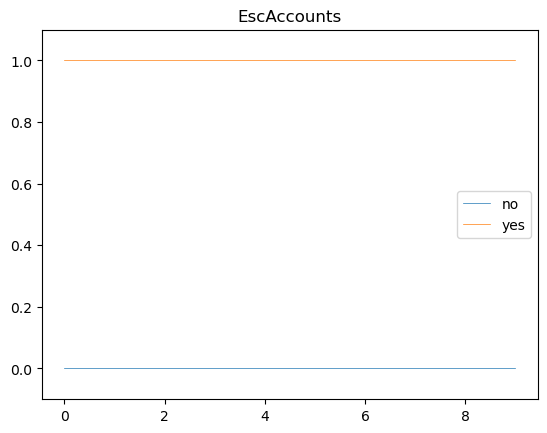

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


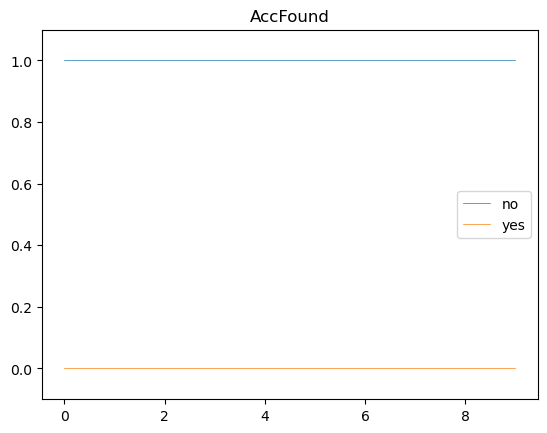

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


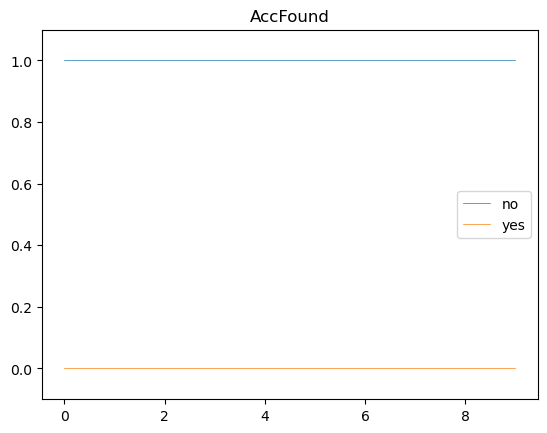

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.723077,0.276923
3,0.944193,0.055807
4,0.961678,0.038322
5,0.946464,0.053536
6,0.946595,0.053406
7,0.946595,0.053405
8,0.946595,0.053405
9,0.946595,0.053405


Plotting ('AccFound', ['no', 'yes']) for agent_j


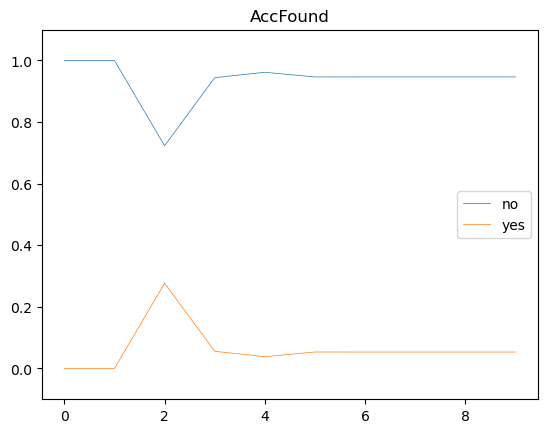

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


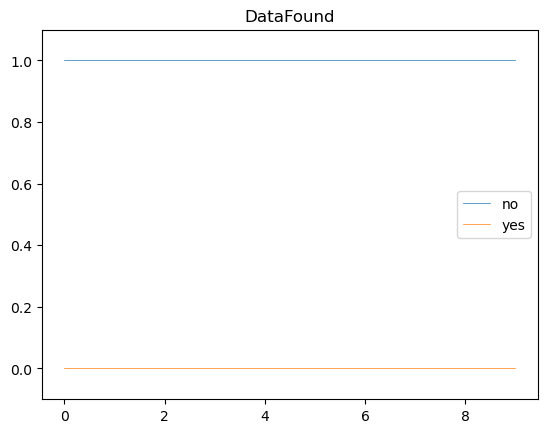

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


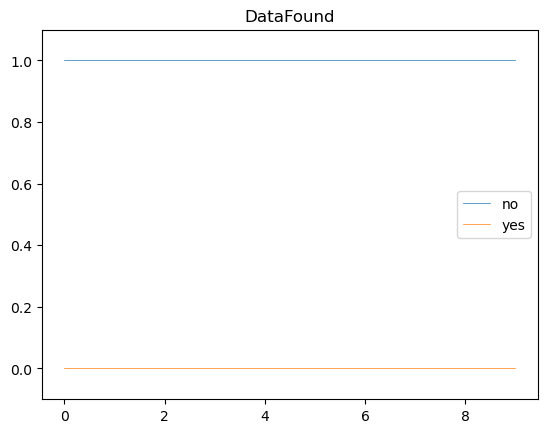

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.200000,0.800000
4,0.199815,0.800185
5,0.196694,0.803306
6,0.196714,0.803286
7,0.196714,0.803286
8,0.196714,0.803285
9,0.196714,0.803286


Plotting ('DataFound', ['no', 'yes']) for agent_j


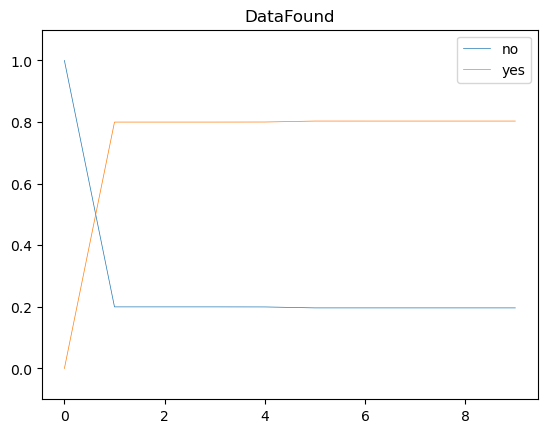

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


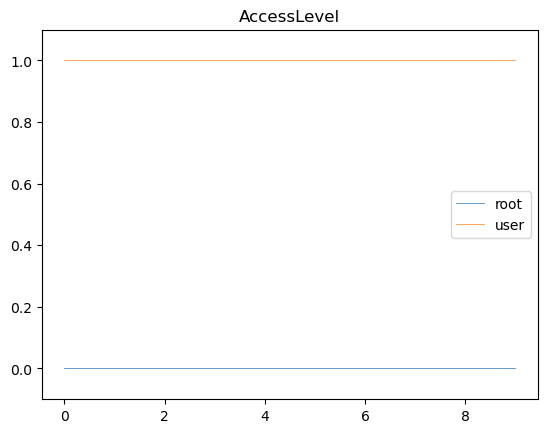

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


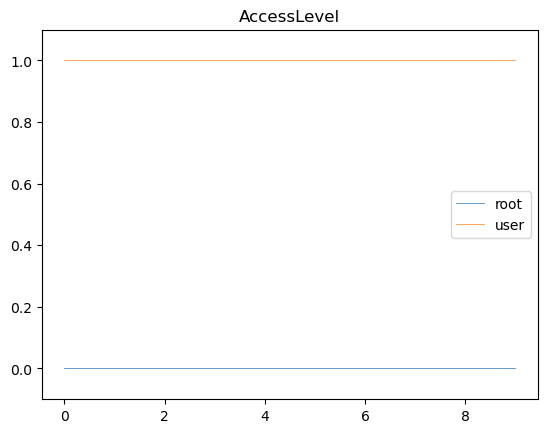

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.019318,0.980682
4,0.001157,0.998843
5,0.016959,0.983041
6,0.016823,0.983177
7,0.016822,0.983178
8,0.016822,0.983178
9,0.016822,0.983178


Plotting ('AccessLevel', ['root', 'user']) for agent_j


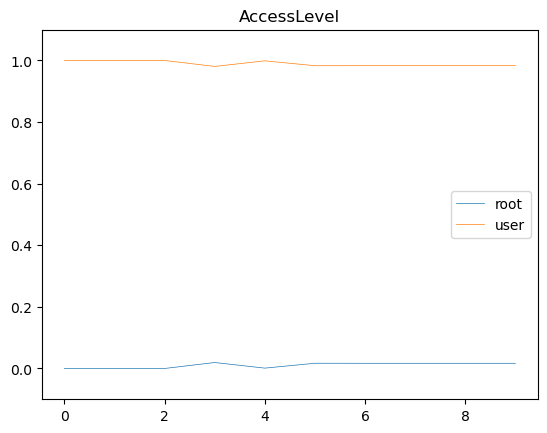

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


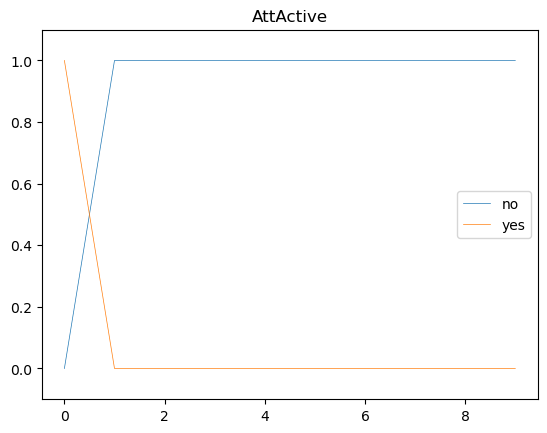

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


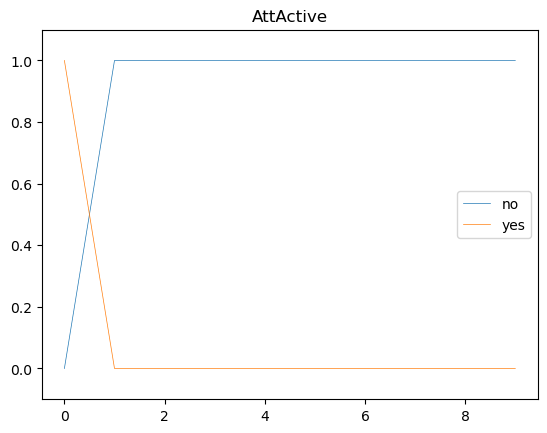

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.653846,3.461539e-01
3,0.980145,1.985452e-02
4,0.998843,1.157391e-03
5,0.983041,1.695864e-02
6,0.999992,8.604437e-06
7,1.000000,5.518565e-08
8,1.000000,0.000000e+00
9,1.000000,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


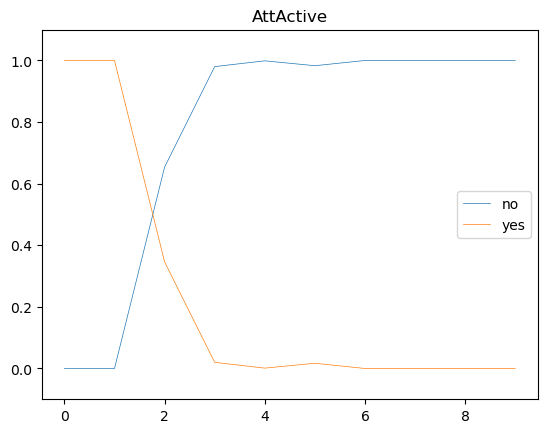

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


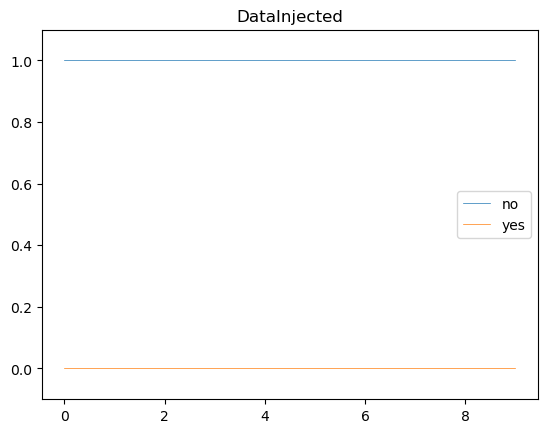

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


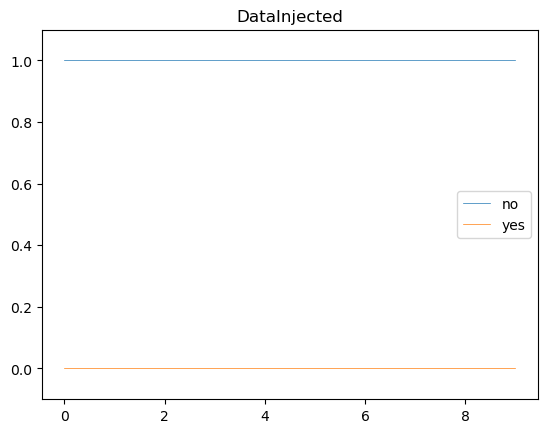

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.983269,0.016731
6,0.983259,0.016741
7,0.983259,0.016741
8,0.983259,0.016741
9,0.983259,0.016741


Plotting ('DataInjected', ['no', 'yes']) for agent_j


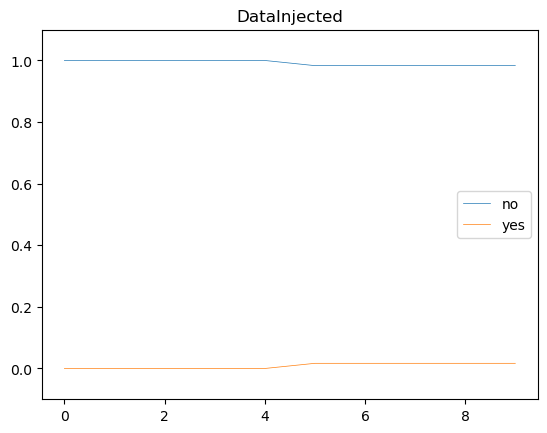

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|user_files|success|terminated|none,RestrictAccPrivs,none
1,Nop,auth|user_files|failure|terminated|none,Nop,none
2,Nop,denied|user_files|failure|terminated|none,Nop,none
3,Nop,denied|none|success|terminated|none,Nop,none
4,Nop,denied|user_files|success|terminated|none,Nop,none
5,Nop,auth|user_files|success|terminated|none,Nop,none
6,Nop,auth|none|success|terminated|none,Nop,none
7,Nop,denied|user_files|success|terminated|none,Nop,none
8,Nop,auth|user_files|success|terminated|none,Nop,none
9,Nop,denied|user_files|success|terminated|none,Nop,file_enum


0	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.5, 'RestrictAccPrivs': 0.5}}
1	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
2	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
3	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
4	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
5	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
6	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0000001, 'RestrictAccPrivs': 0.0}}
7	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.99999994, 'RestrictAccPrivs': 0.0}}
8	{'DefActions': {'DecoyAccount': 0.0, 'DeployData'

,highCap,lowCap
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


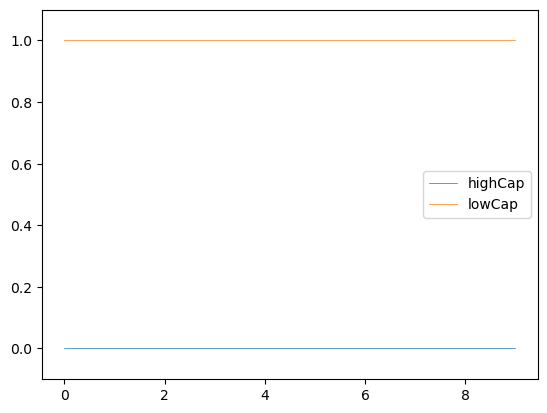

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


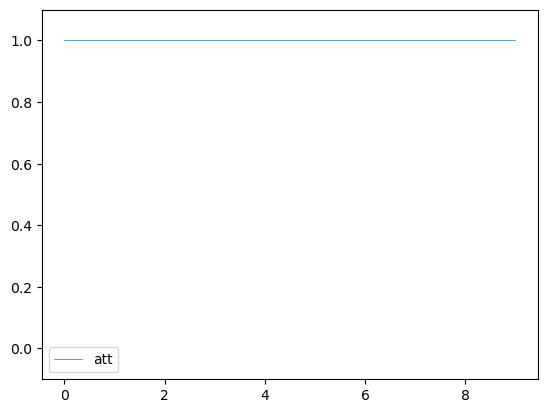

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


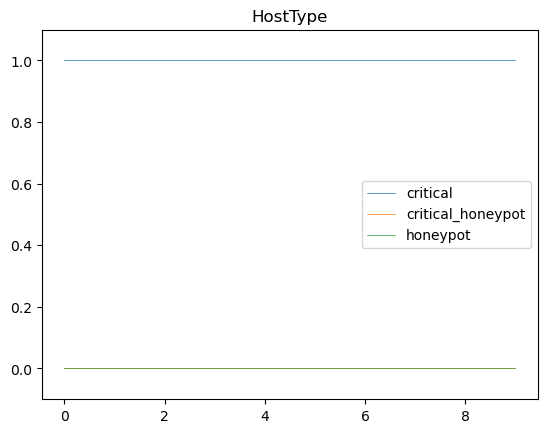

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


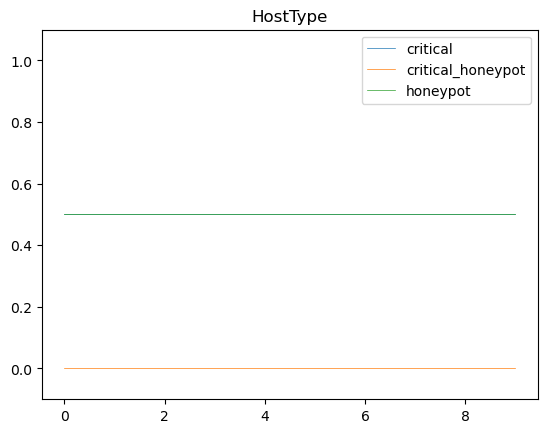

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


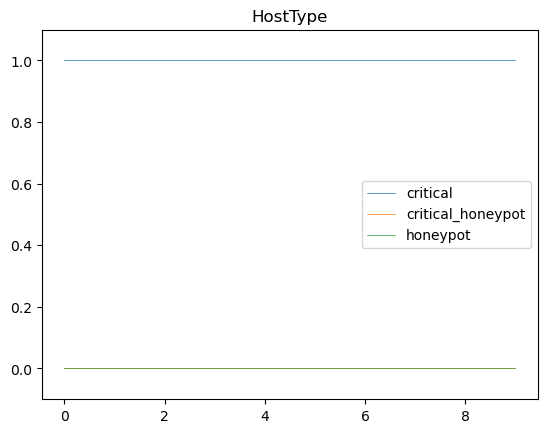

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


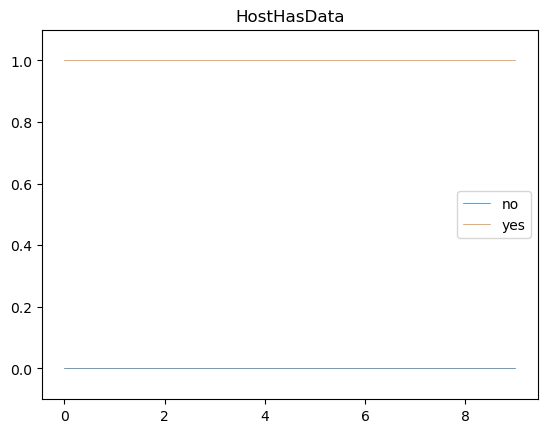

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


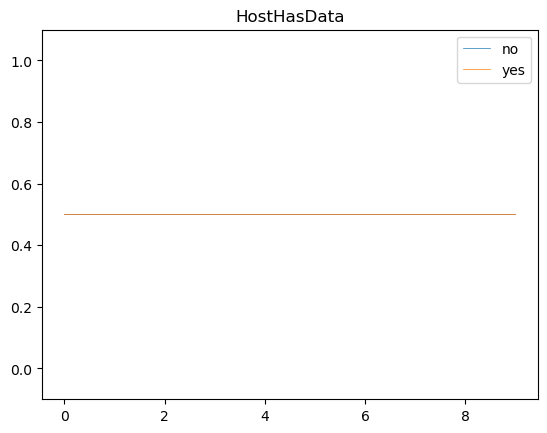

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


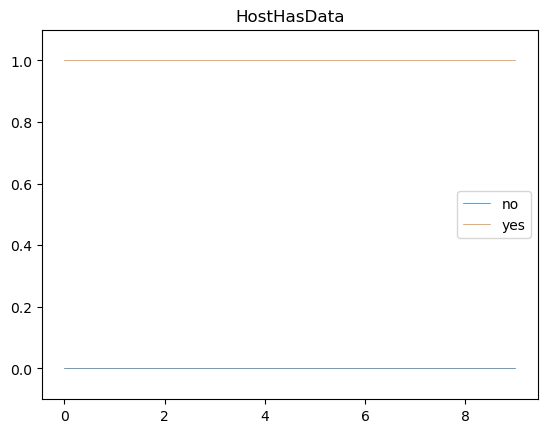

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


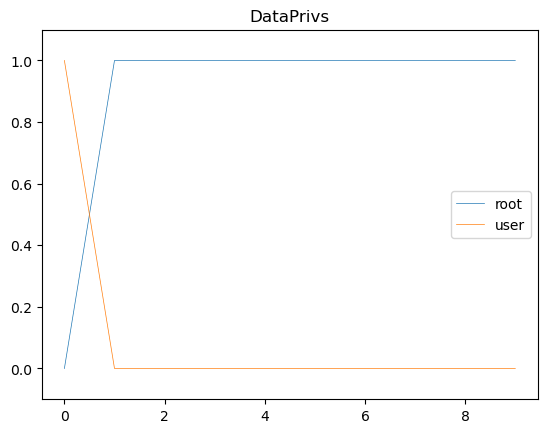

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.50,0.50
1,0.75,0.25
2,0.75,0.25
3,0.75,0.25
4,0.75,0.25
5,0.75,0.25
6,0.75,0.25
7,0.75,0.25
8,0.75,0.25
9,0.75,0.25


Plotting ('DataPrivs', ['root', 'user']) for agent_i


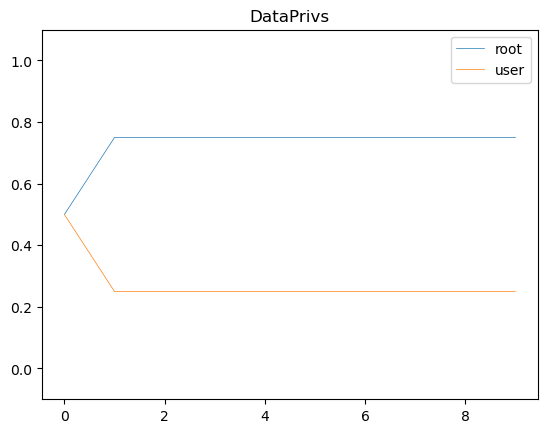

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


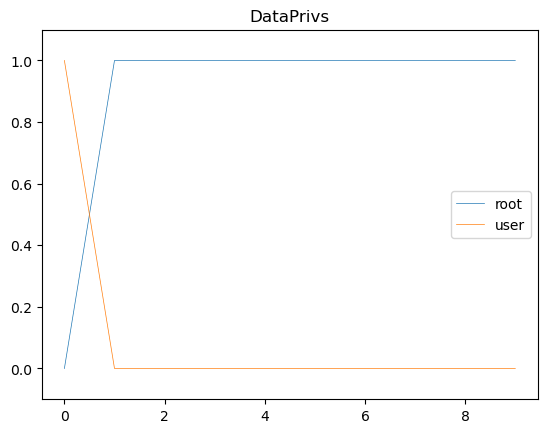

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


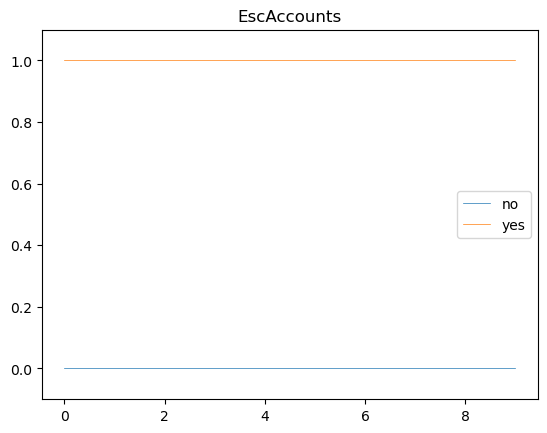

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


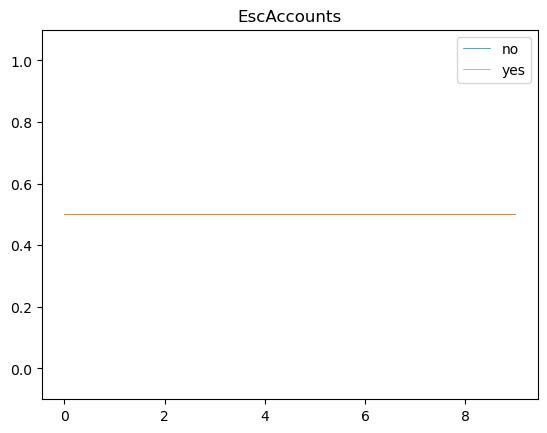

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


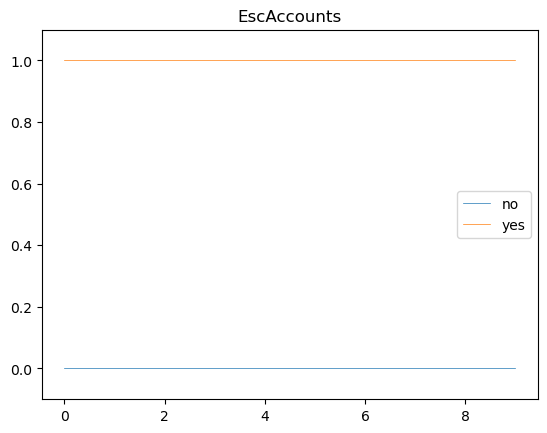

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


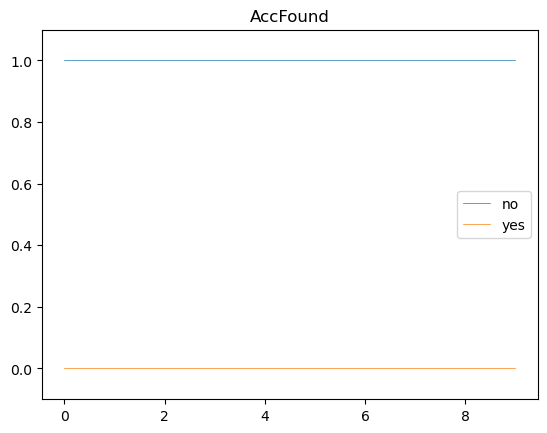

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


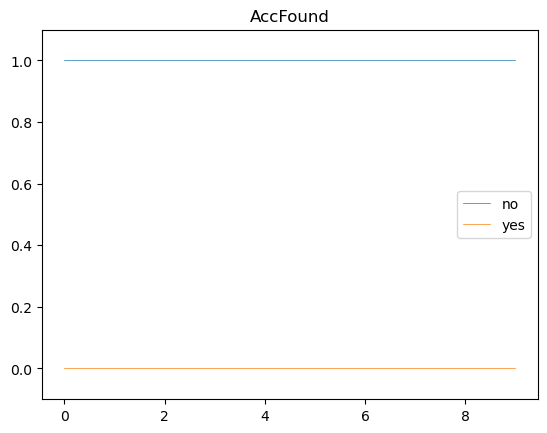

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.723077,0.276923
3,0.944193,0.055807
4,0.961678,0.038322
5,0.962726,0.037274
6,0.962734,0.037266
7,0.962734,0.037266
8,0.962734,0.037266
9,0.962734,0.037266


Plotting ('AccFound', ['no', 'yes']) for agent_j


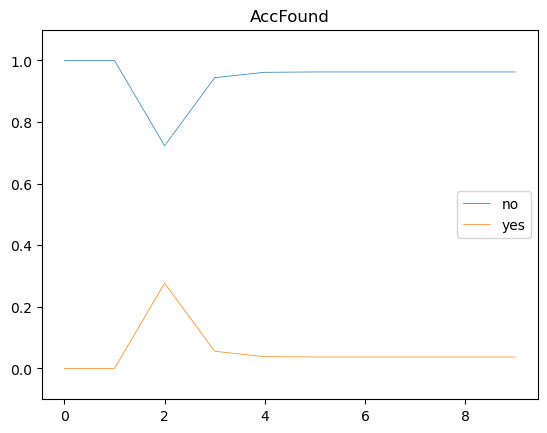

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


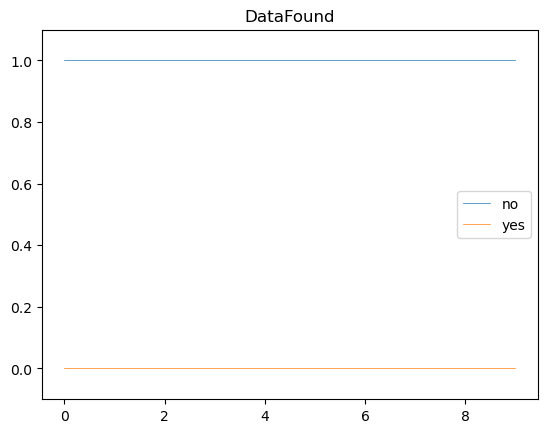

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


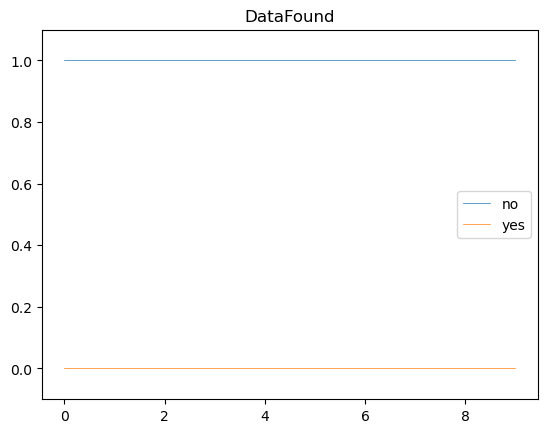

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.200000,0.800000
4,0.199815,0.800185
5,0.199987,0.800013
6,0.199988,0.800012
7,0.199988,0.800012
8,0.199988,0.800012
9,0.199988,0.800012


Plotting ('DataFound', ['no', 'yes']) for agent_j


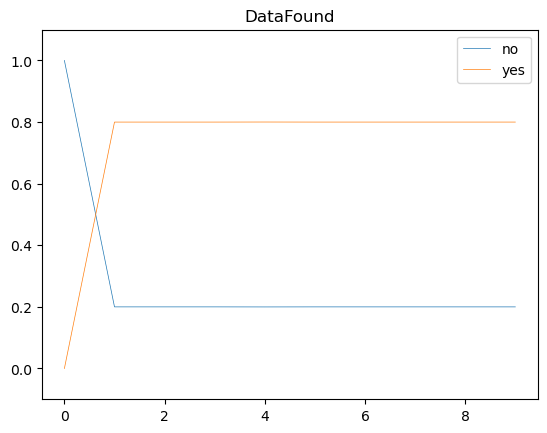

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


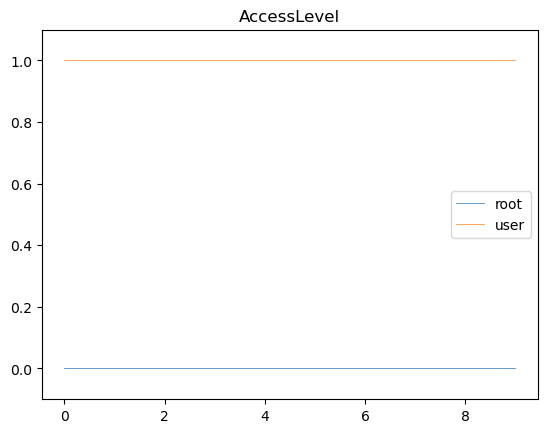

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


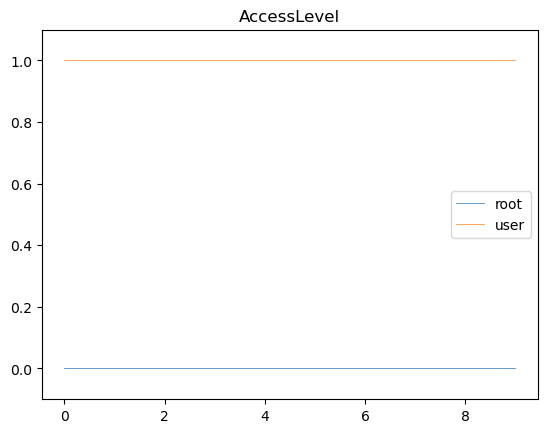

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.019318,0.980682
4,0.001157,0.998843
5,0.000068,0.999932
6,0.000060,0.999940
7,0.000060,0.999940
8,0.000060,0.999940
9,0.000060,0.999940


Plotting ('AccessLevel', ['root', 'user']) for agent_j


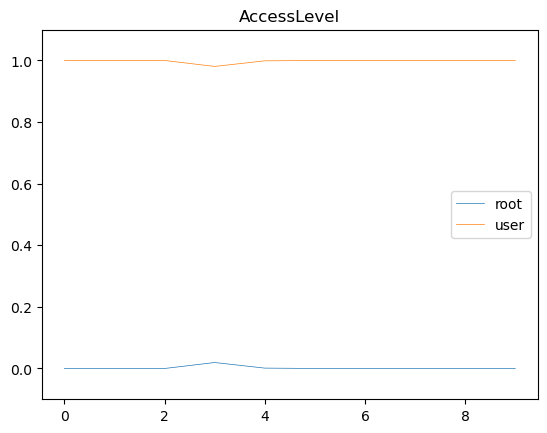

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


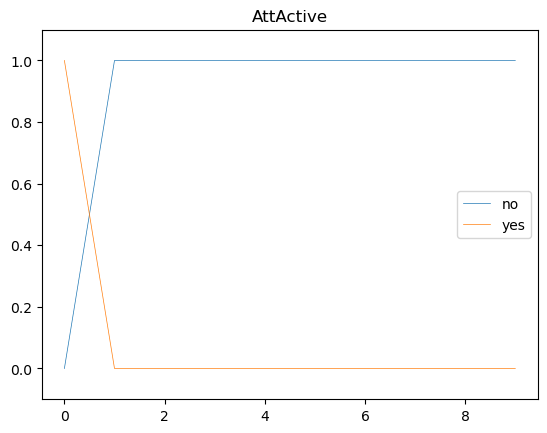

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


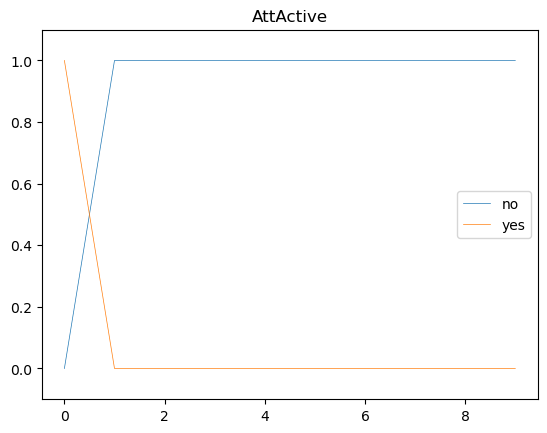

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.653846,3.461539e-01
3,0.980145,1.985452e-02
4,0.998843,1.157391e-03
5,0.999932,6.815605e-05
6,1.000000,5.147733e-07
7,1.000000,3.301561e-09
8,1.000000,0.000000e+00
9,1.000000,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


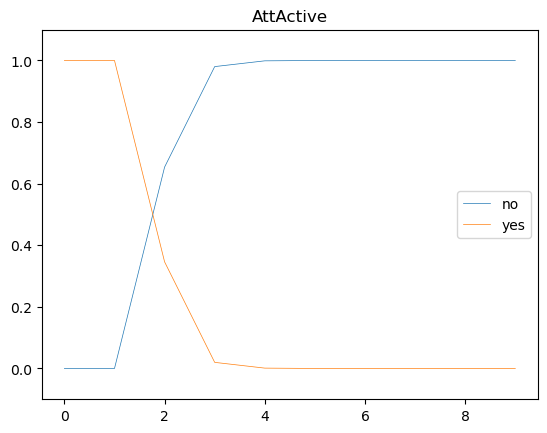

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


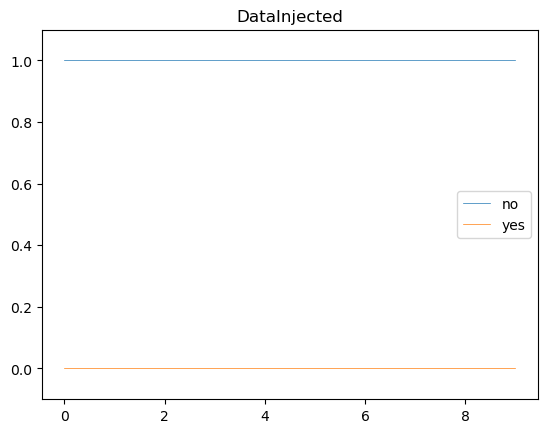

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


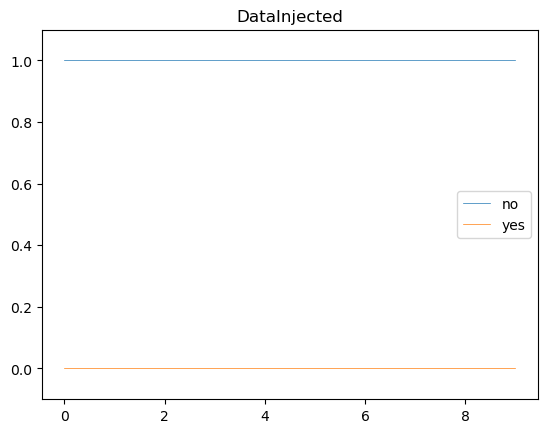

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.999941,0.000059
6,0.999941,0.000059
7,0.999941,0.000059
8,0.999941,0.000059
9,0.999941,0.000059


Plotting ('DataInjected', ['no', 'yes']) for agent_j


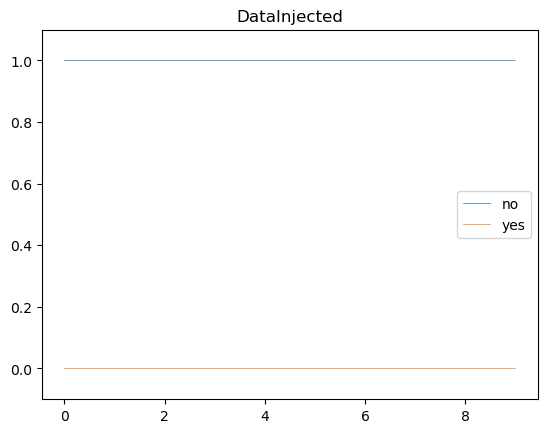

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|user_files|failure|terminated|none,RestrictAccPrivs,none
1,Nop,auth|user_files|success|terminated|none,Nop,none
2,Nop,auth|user_files|failure|terminated|none,Nop,none
3,Nop,denied|none|failure|terminated|none,Nop,none
4,Nop,denied|none|failure|terminated|none,Nop,none
5,Nop,denied|none|success|terminated|none,Nop,none
6,Nop,auth|none|failure|terminated|none,Nop,none
7,Nop,auth|user_files|failure|terminated|none,Nop,none
8,Nop,denied|none|failure|terminated|none,Nop,none
9,Nop,denied|none|failure|terminated|none,Nop,none


0	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.5, 'RestrictAccPrivs': 0.5}}
1	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
2	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
3	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
4	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
5	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0, 'RestrictAccPrivs': 0.0}}
6	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 1.0000001, 'RestrictAccPrivs': 0.0}}
7	{'DefActions': {'DecoyAccount': 0.0, 'DeployData': 0.0, 'LockAccounts': 0.0, 'Nop': 0.99999994, 'RestrictAccPrivs': 0.0}}
8	{'DefActions': {'DecoyAccount': 0.0, 'DeployData'

,highCap,lowCap
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


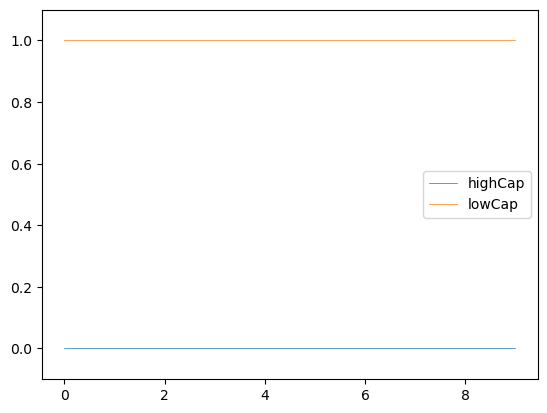

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


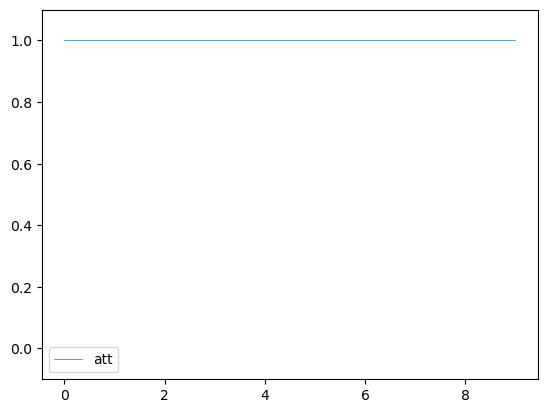

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


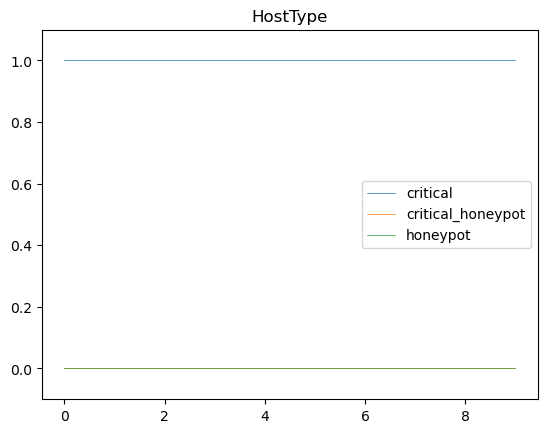

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


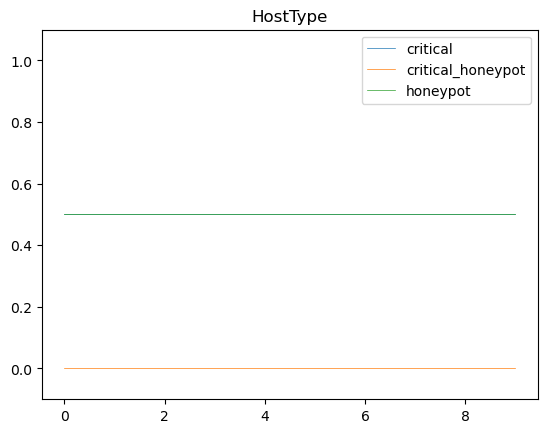

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


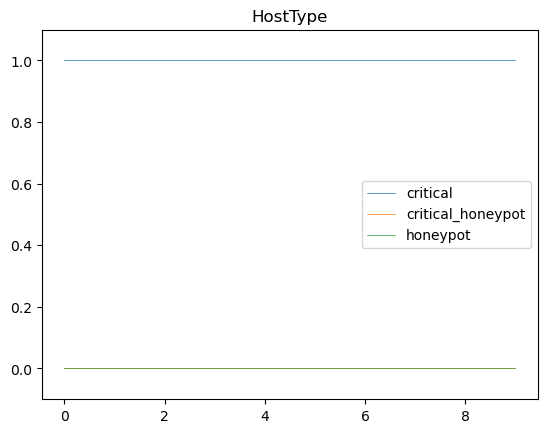

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


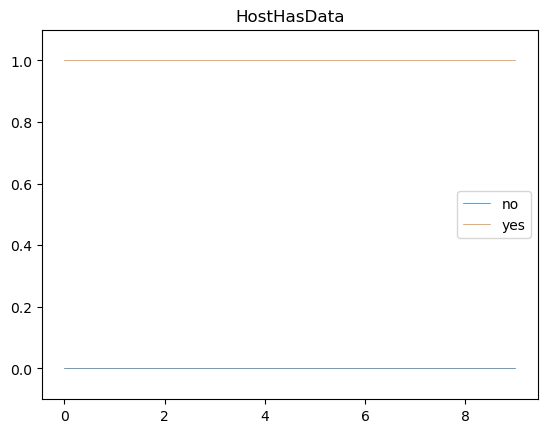

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


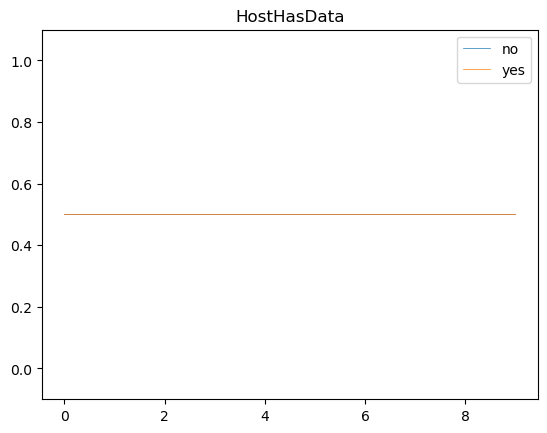

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


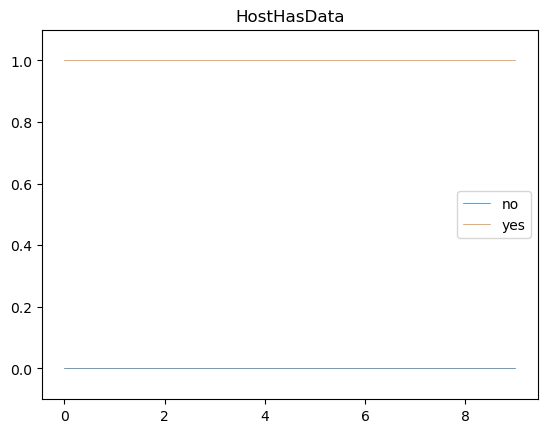

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


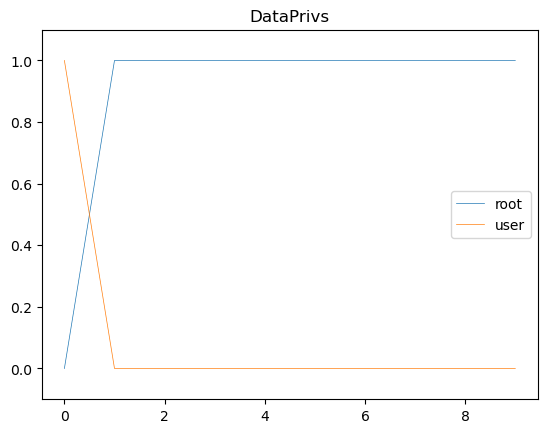

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.50,0.50
1,0.75,0.25
2,0.75,0.25
3,0.75,0.25
4,0.75,0.25
5,0.75,0.25
6,0.75,0.25
7,0.75,0.25
8,0.75,0.25
9,0.75,0.25


Plotting ('DataPrivs', ['root', 'user']) for agent_i


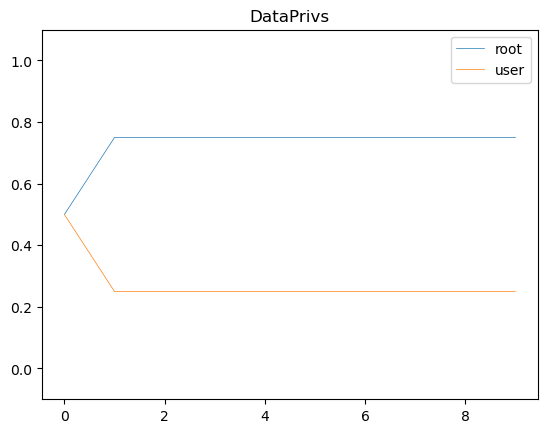

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


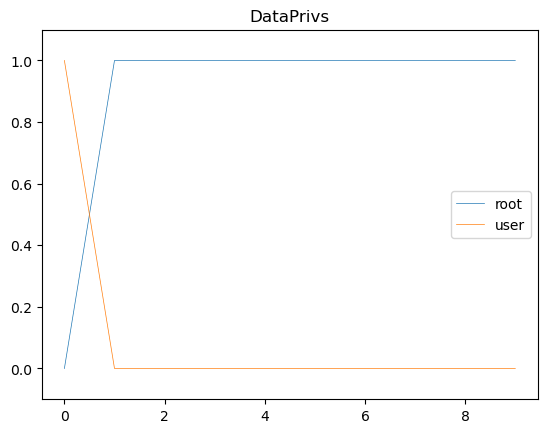

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


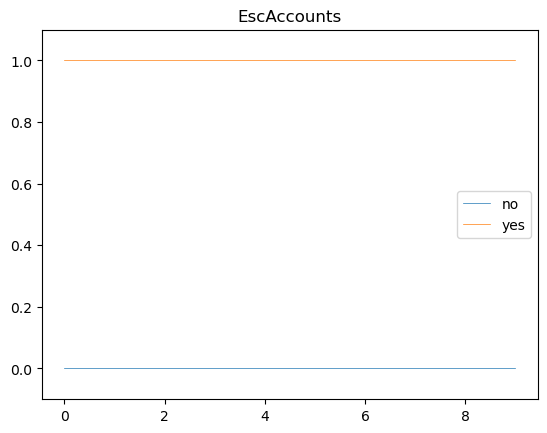

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


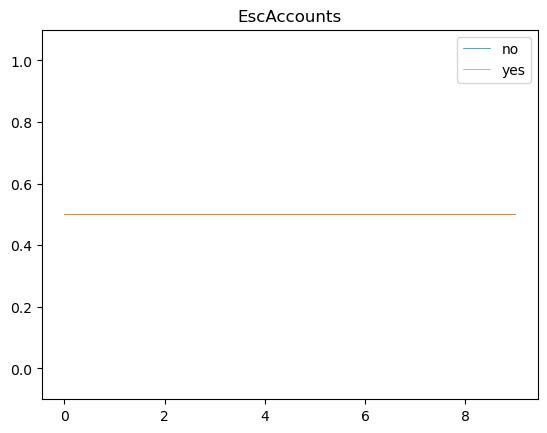

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


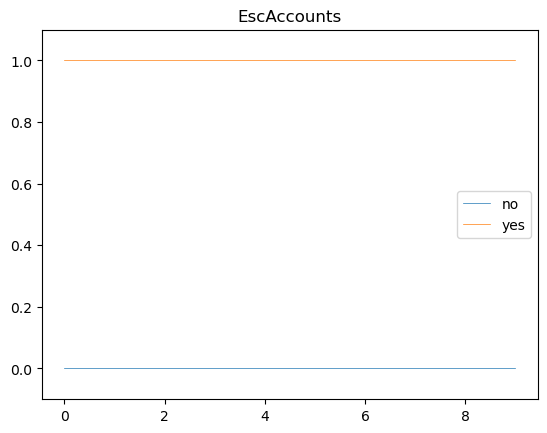

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


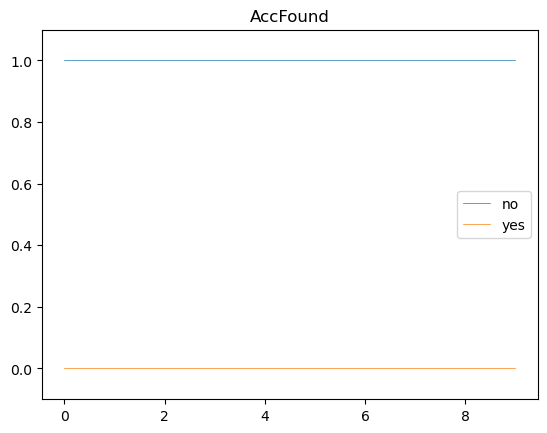

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


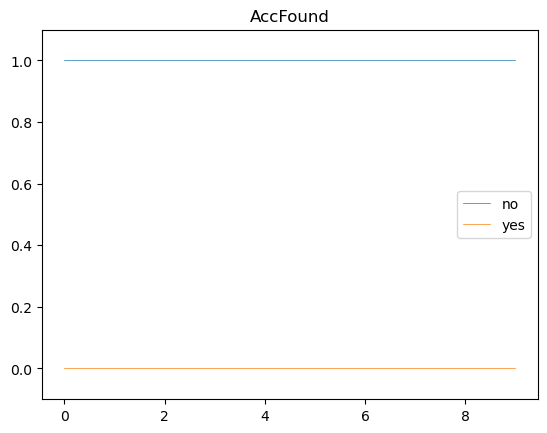

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.723077,0.276923
3,0.944193,0.055807
4,0.961678,0.038322
5,0.962726,0.037274
6,0.962734,0.037266
7,0.962734,0.037266
8,0.962734,0.037266
9,0.962734,0.037266


Plotting ('AccFound', ['no', 'yes']) for agent_j


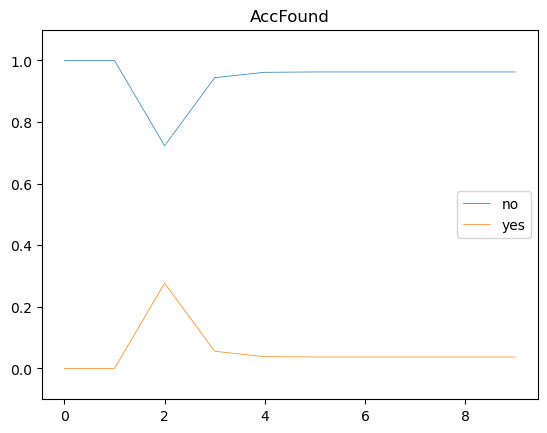

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


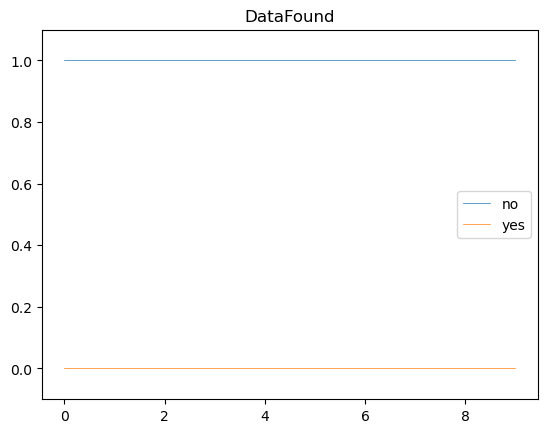

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


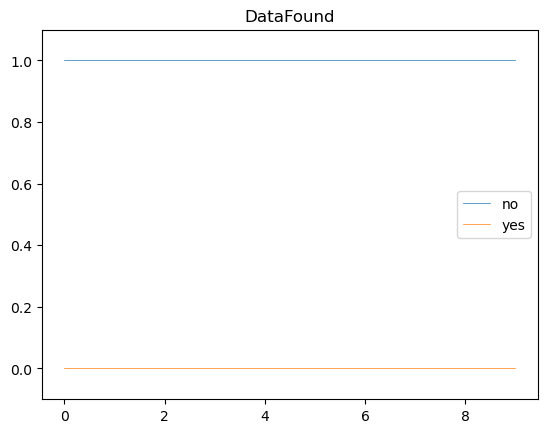

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.200000,0.800000
4,0.199815,0.800185
5,0.199987,0.800013
6,0.199988,0.800012
7,0.199988,0.800012
8,0.199988,0.800012
9,0.199988,0.800012


Plotting ('DataFound', ['no', 'yes']) for agent_j


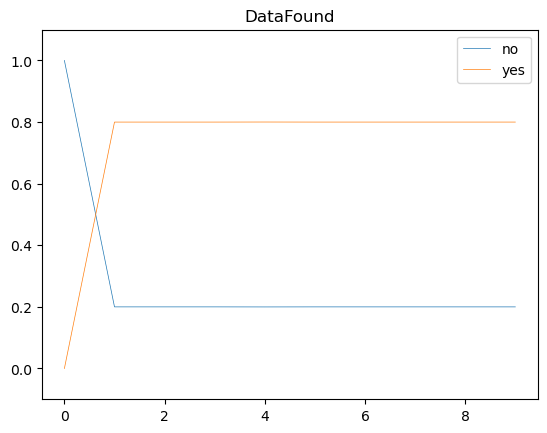

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


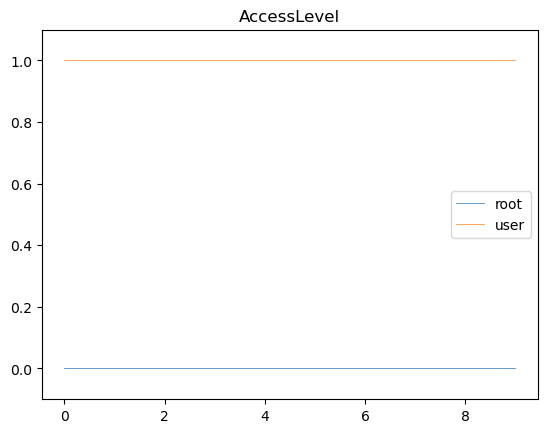

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


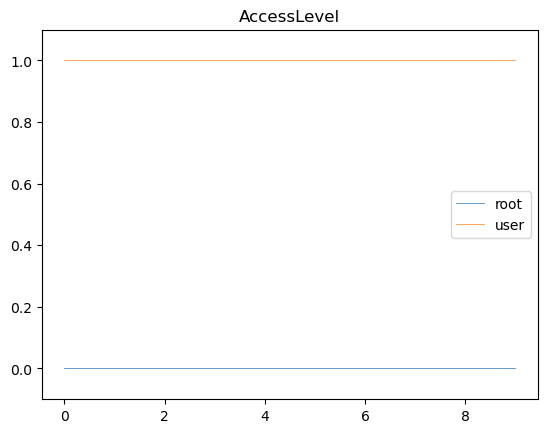

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.019318,0.980682
4,0.001157,0.998843
5,0.000068,0.999932
6,0.000060,0.999940
7,0.000060,0.999940
8,0.000060,0.999940
9,0.000060,0.999940


Plotting ('AccessLevel', ['root', 'user']) for agent_j


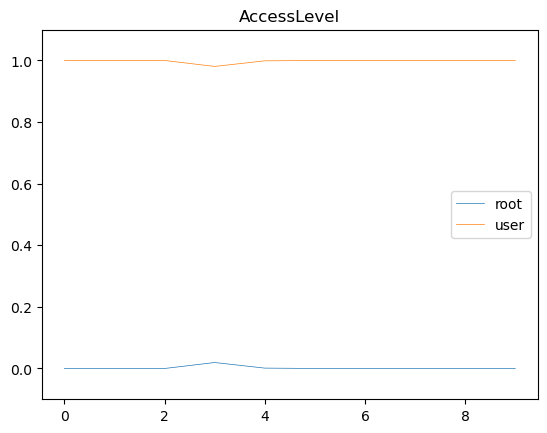

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


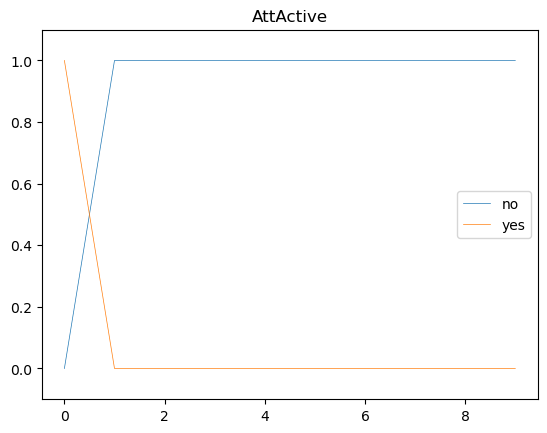

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


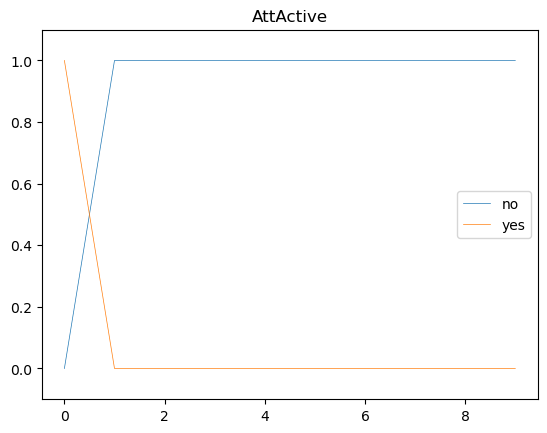

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.653846,3.461539e-01
3,0.980145,1.985452e-02
4,0.998843,1.157391e-03
5,0.999932,6.815605e-05
6,1.000000,5.147733e-07
7,1.000000,3.301561e-09
8,1.000000,0.000000e+00
9,1.000000,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


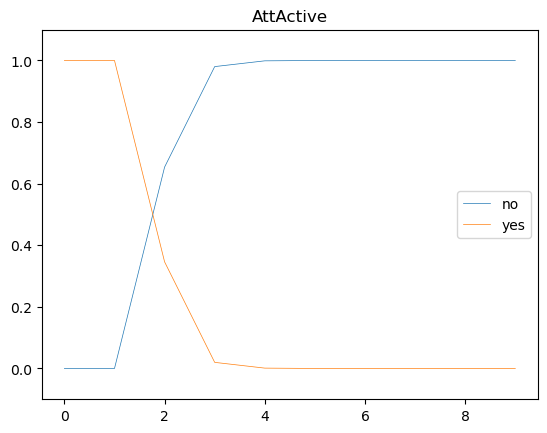

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


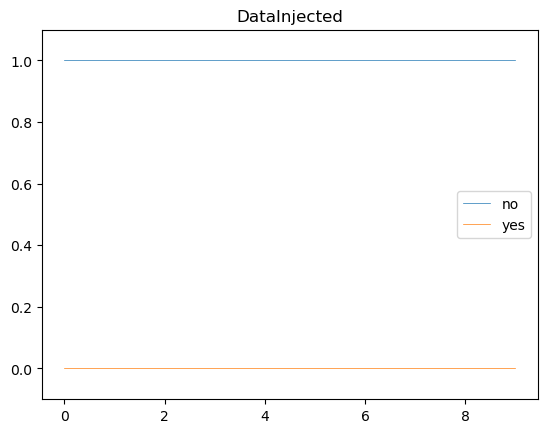

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


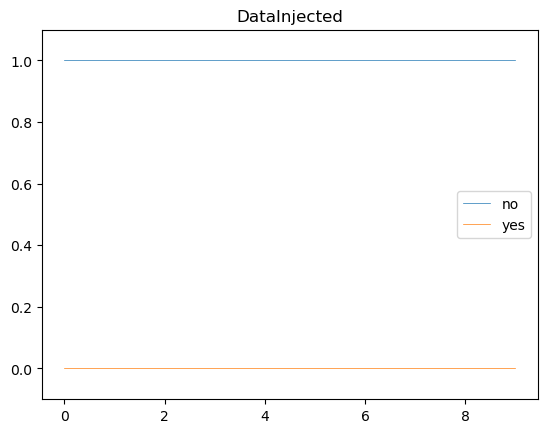

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.999941,0.000059
6,0.999941,0.000059
7,0.999941,0.000059
8,0.999941,0.000059
9,0.999941,0.000059


Plotting ('DataInjected', ['no', 'yes']) for agent_j


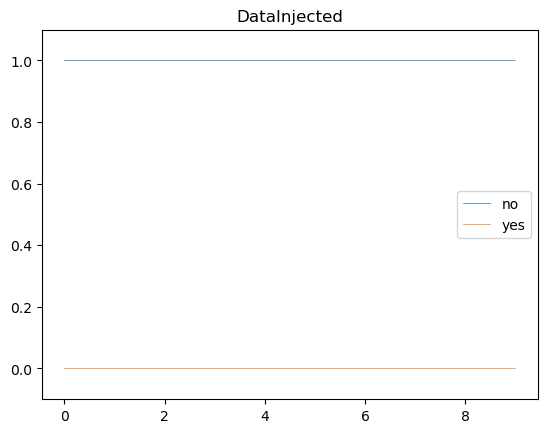

=============== End interaction trace


In [11]:
from IPython.display import display, HTML

for trace in data[:5]:
    actions = summarize_interaction.pull_actions(trace)
    display(actions)
    
    try:
        frame_beliefs = summarize_interaction.pull_frame_beliefs(trace)
        
        i_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "i_P(Aj)")
        j_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "j_P(Aj)")
        
        for i, i_pred in enumerate(i_PAj):
            print(f"{i}\t{i_pred}")

        for _b_theta in frame_beliefs:
            display(_b_theta)
            _b_theta.plot(linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()

        for k in keys:
            beliefs = summarize_interaction.show_belief(trace, k)

            for _b in beliefs.keys():
                print(f"Showing {k} for {_b}")
                display(beliefs[_b])

                print(f"Plotting {k} for {_b}")
                beliefs[_b].plot(legend=True, title=k[0], linewidth=0.5)
                plotter.ylim(-0.1, 1.1)
                plotter.show()

        print("=============== End interaction trace")
    except Exception:
        passx